# Single Cell RNA Analysis

In this analysis we will be using data generated to observe the role of tissue resident macrophages in active rheumatoid arthritis and remission in the synovium. https://www.nature.com/articles/s41591-020-0939-8. 

Data : https://www.ebi.ac.uk/biostudies/arrayexpress. 

For this analysis will use following samples : HC0572,HC0701,SA168,SA138,SA131


### Donloading the data

Data : https://www.ebi.ac.uk/biostudies/arrayexpress.

Now we have downloaded our data in folder

In [ ]:
library(Seurat)
library(harmony)
library(clustree)
library(data.table)
library(tidyverse)
library(RColorBrewer)
library(clusterProfiler)
library(org.Hs.eg.db)
library(scProportionTest)
                

In [ ]:
base.data.dir <- "/Data/E-MTAB-8322/"
sample_ids <- c("HC0701", "HC0572", "SA168", "SA138", "SA131")

directory.list <- c()

for (sample in sample_ids) {
    file.dir <- paste0(base.data.dir,sample)
    directory.list[[length(directory.list) + 1]] <- file.dir
}

directory.list

In [4]:
matrix.list <- list()
for (directory in directory.list) {
    x <- Read10X(directory)
    x <- CreateSeuratObject(x)
    x$Sample <- sub(".*/", "", directory)
    x$Group <- ifelse(grepl("HC", x$Sample), "Healthy", 
                      ifelse(grepl("SA13", x$Sample), "Naive RA", "Remission"))
    matrix.list[[length(matrix.list) + 1]] <- x
}
matrix.list

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


[[1]]
An object of class Seurat 
33694 features across 2102 samples within 1 assay 
Active assay: RNA (33694 features, 0 variable features)
 1 layer present: counts

[[2]]
An object of class Seurat 
33694 features across 1699 samples within 1 assay 
Active assay: RNA (33694 features, 0 variable features)
 1 layer present: counts

[[3]]
An object of class Seurat 
33694 features across 5067 samples within 1 assay 
Active assay: RNA (33694 features, 0 variable features)
 1 layer present: counts

[[4]]
An object of class Seurat 
33694 features across 1885 samples within 1 assay 
Active assay: RNA (33694 features, 0 variable features)
 1 layer present: counts

[[5]]
An object of class Seurat 
33694 features across 591 samples within 1 assay 
Active assay: RNA (33694 features, 0 variable features)
 1 layer present: counts


## Quality Control

The first thing we do when analyzing our data is to ensure its quality. This involves being very careful about the criteria we use to remove any cells that might be of poor quality and could mess up our later analyses. 

#### nFeatureRNA
nFeatureRNA indicates the number of unique genes we have detected in each cell. 

#### nCountRNA
nCountRNA is the number of molecules that we have detected within each cell.

#### percent.mt
This metric measures the proportion of reads in the data that align with the mitochondrial genome. Essentially, it helps us understand what percentage of the genes detected in a cell are related to mitochondrial gene expression.

In [6]:
all_samples[["percent.mt"]] <- PercentageFeatureSet(all_samples, pattern = "^MT-")

In [ ]:
VlnPlot(all_samples, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3, pt.size = 0)

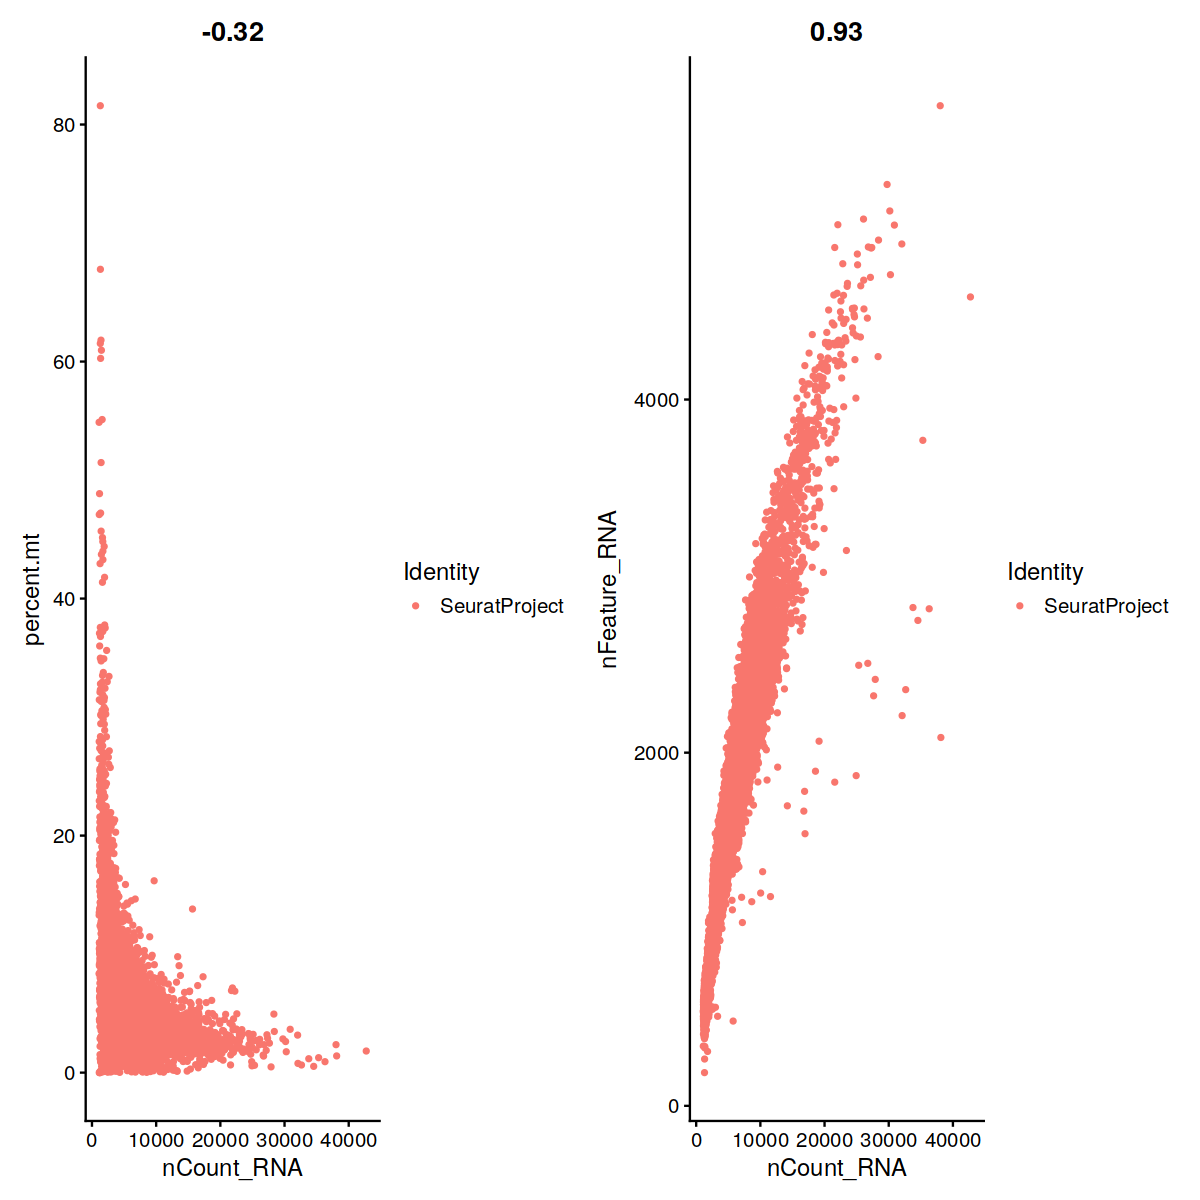

In [8]:
options(repr.plot.width=10, repr.plot.height=10)
plot1 <- FeatureScatter(all_samples, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(all_samples, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1 + plot2

In [9]:
all_samples <- subset(all_samples, subset = nFeature_RNA > 200 & nFeature_RNA < 4000 & percent.mt < 20)
all_samples

An object of class Seurat 
33694 features across 11071 samples within 1 assay 
Active assay: RNA (33694 features, 0 variable features)
 5 layers present: counts.1, counts.2, counts.3, counts.4, counts.5

During the QC we can define  the  same filtering parameters on all samples but some times we may loose important features or can add required data by doing this. It recomends to see the each sample and decide filtering parameters based on that which will make analysis more robust.

In [10]:
matrix.list <- lapply(matrix.list, function(object) {
  object[["percent.mt"]] <- PercentageFeatureSet(object, pattern = "^MT-")
  object
})

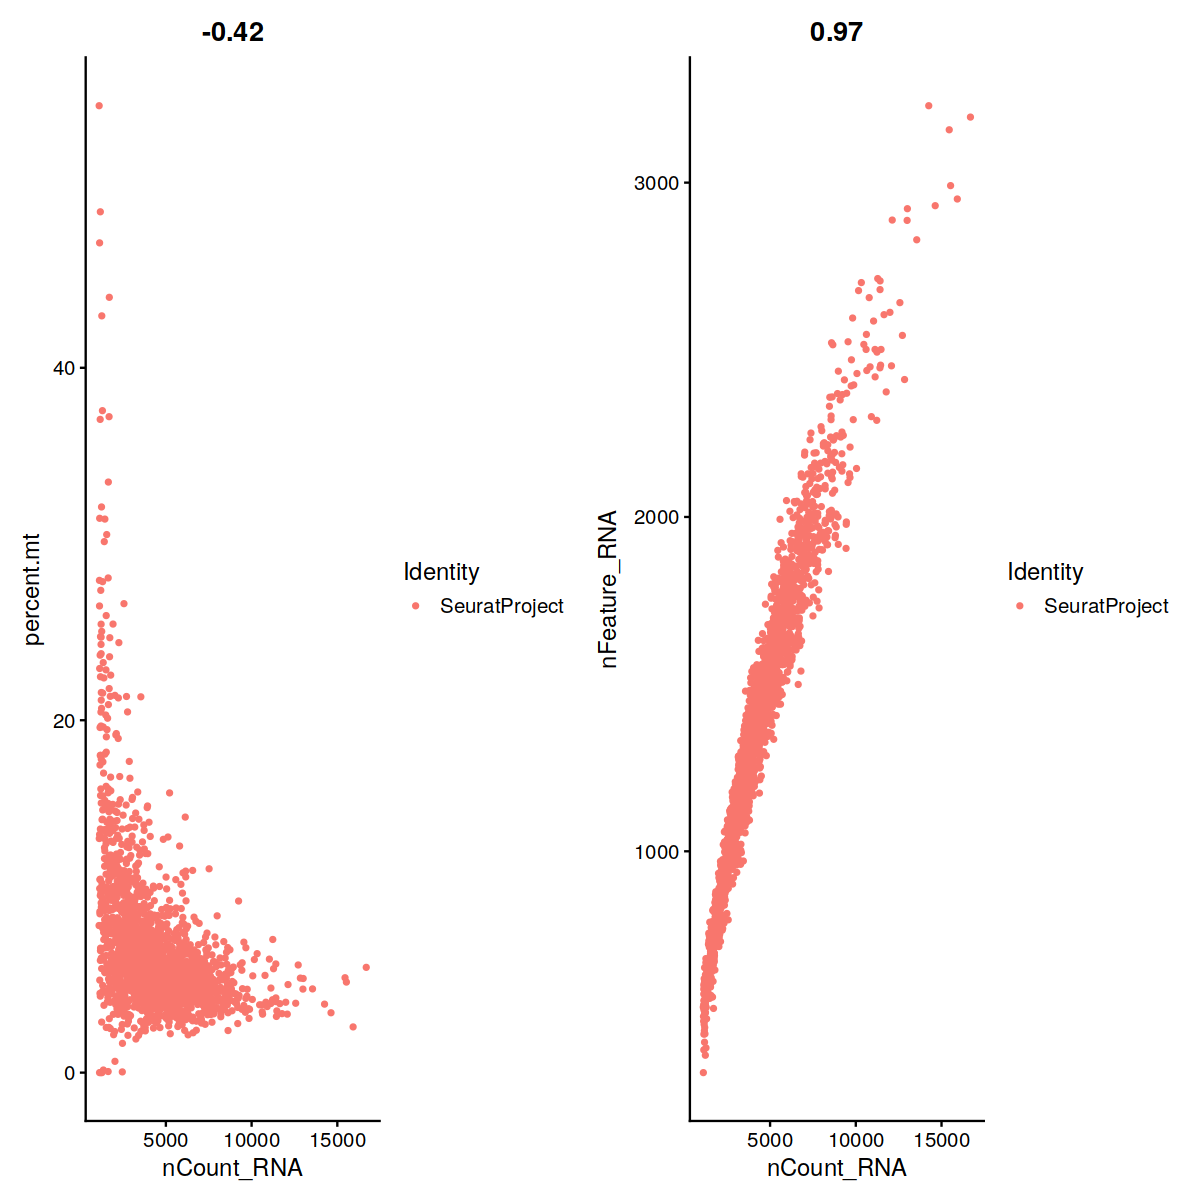

In [11]:
options(repr.plot.width=10, repr.plot.height=10)
plot1 <- FeatureScatter(matrix.list[[1]], feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(matrix.list[[1]], feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1 + plot2

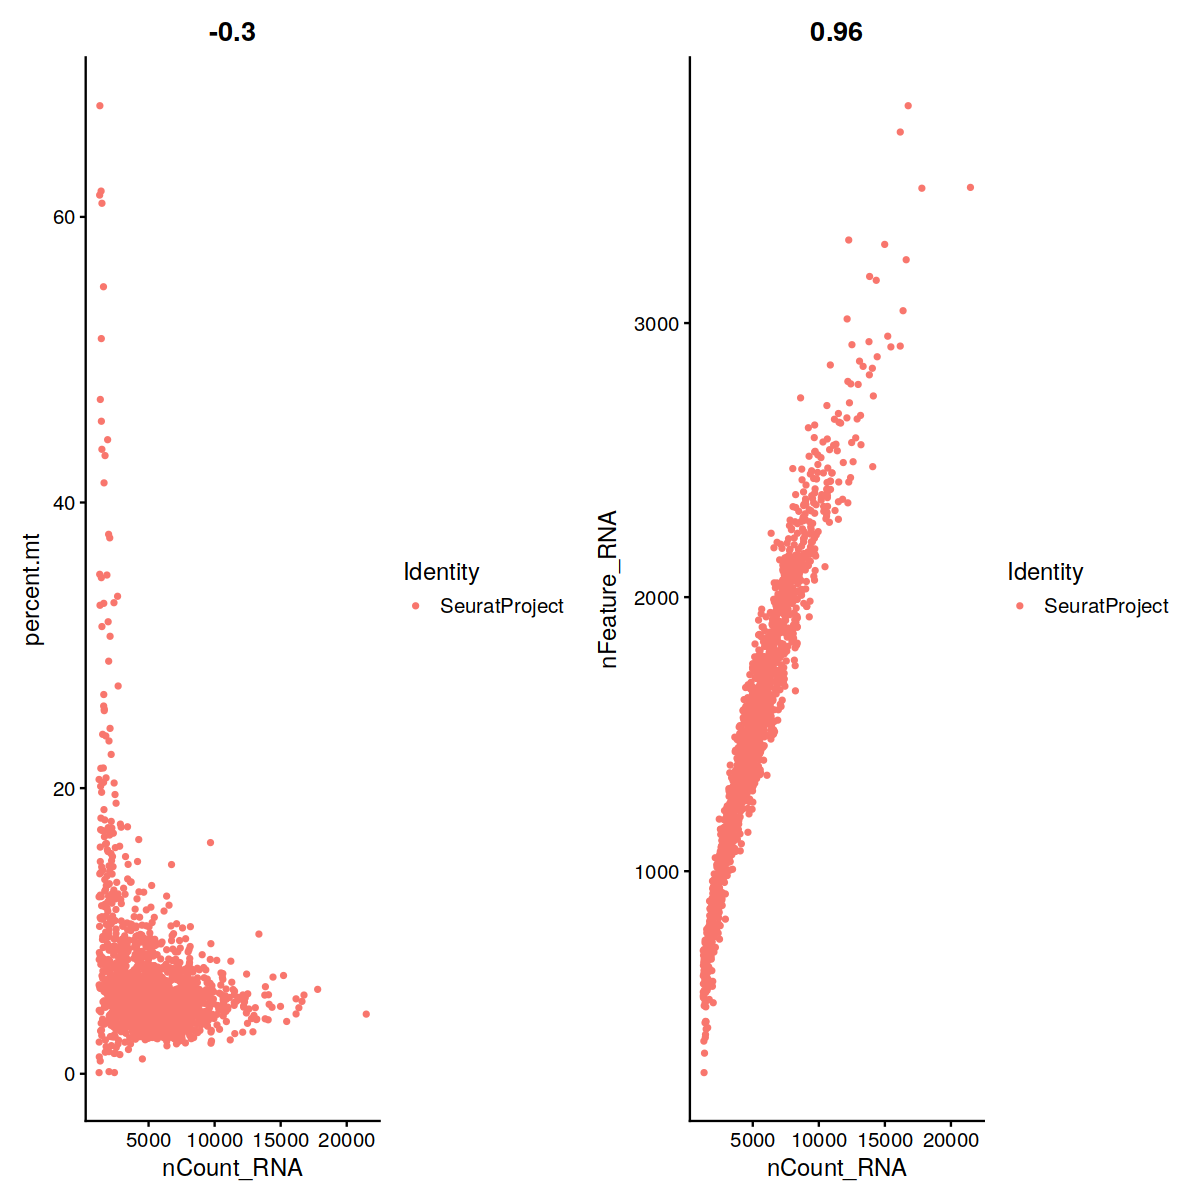

In [12]:
options(repr.plot.width=10, repr.plot.height=10)
plot1 <- FeatureScatter(matrix.list[[2]], feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(matrix.list[[2]], feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1 + plot2

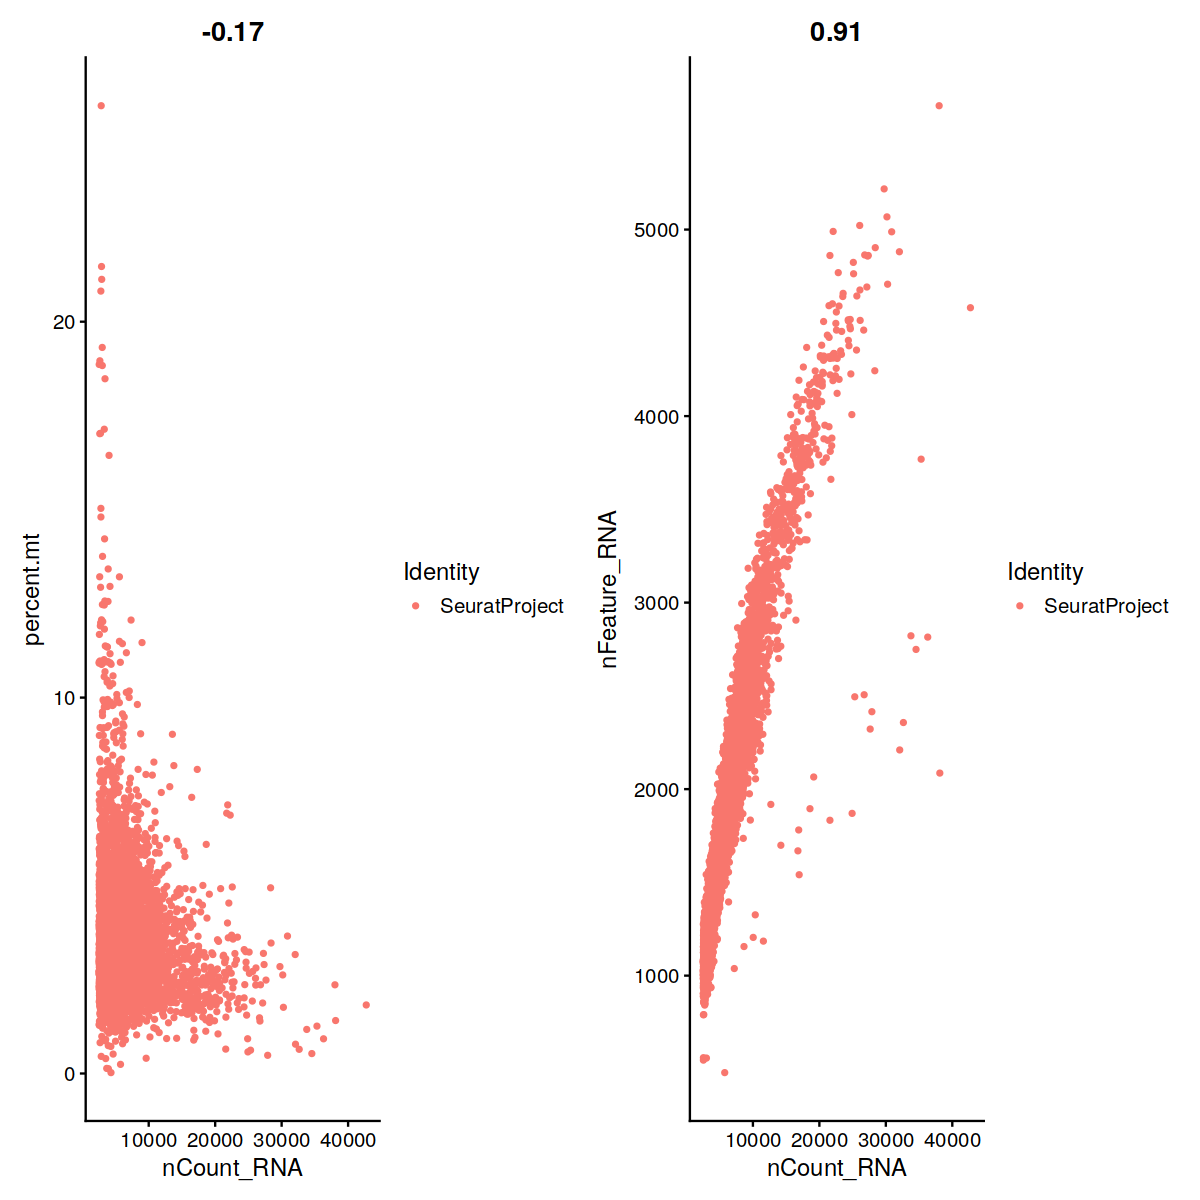

In [13]:
options(repr.plot.width=10, repr.plot.height=10)
plot1 <- FeatureScatter(matrix.list[[3]], feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(matrix.list[[3]], feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1 + plot2

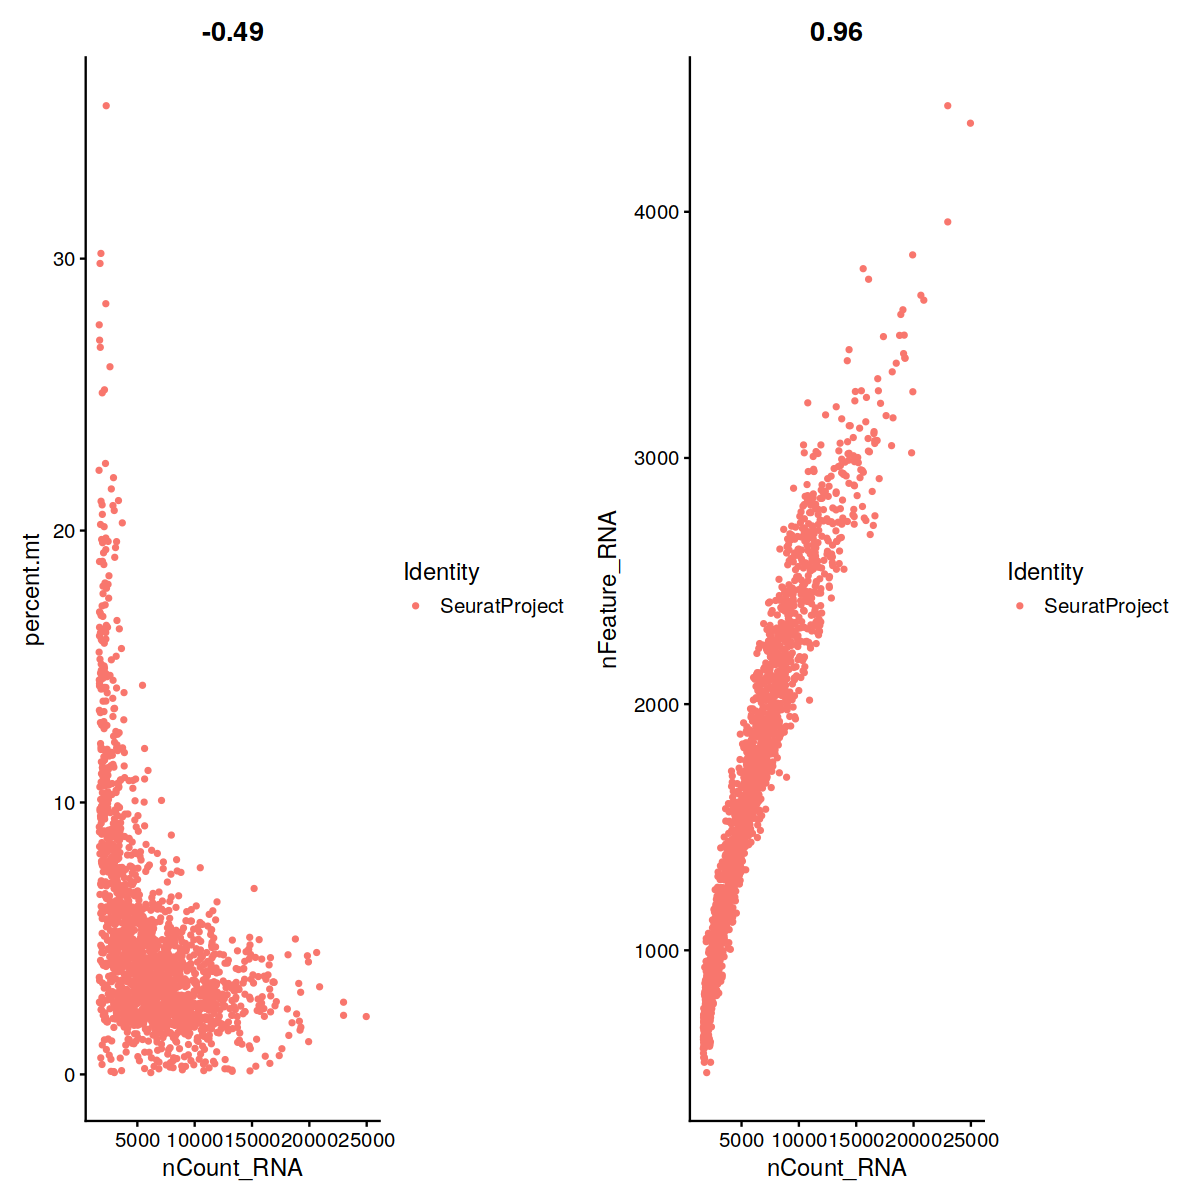

In [14]:
options(repr.plot.width=10, repr.plot.height=10)
plot1 <- FeatureScatter(matrix.list[[4]], feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(matrix.list[[4]], feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1 + plot2

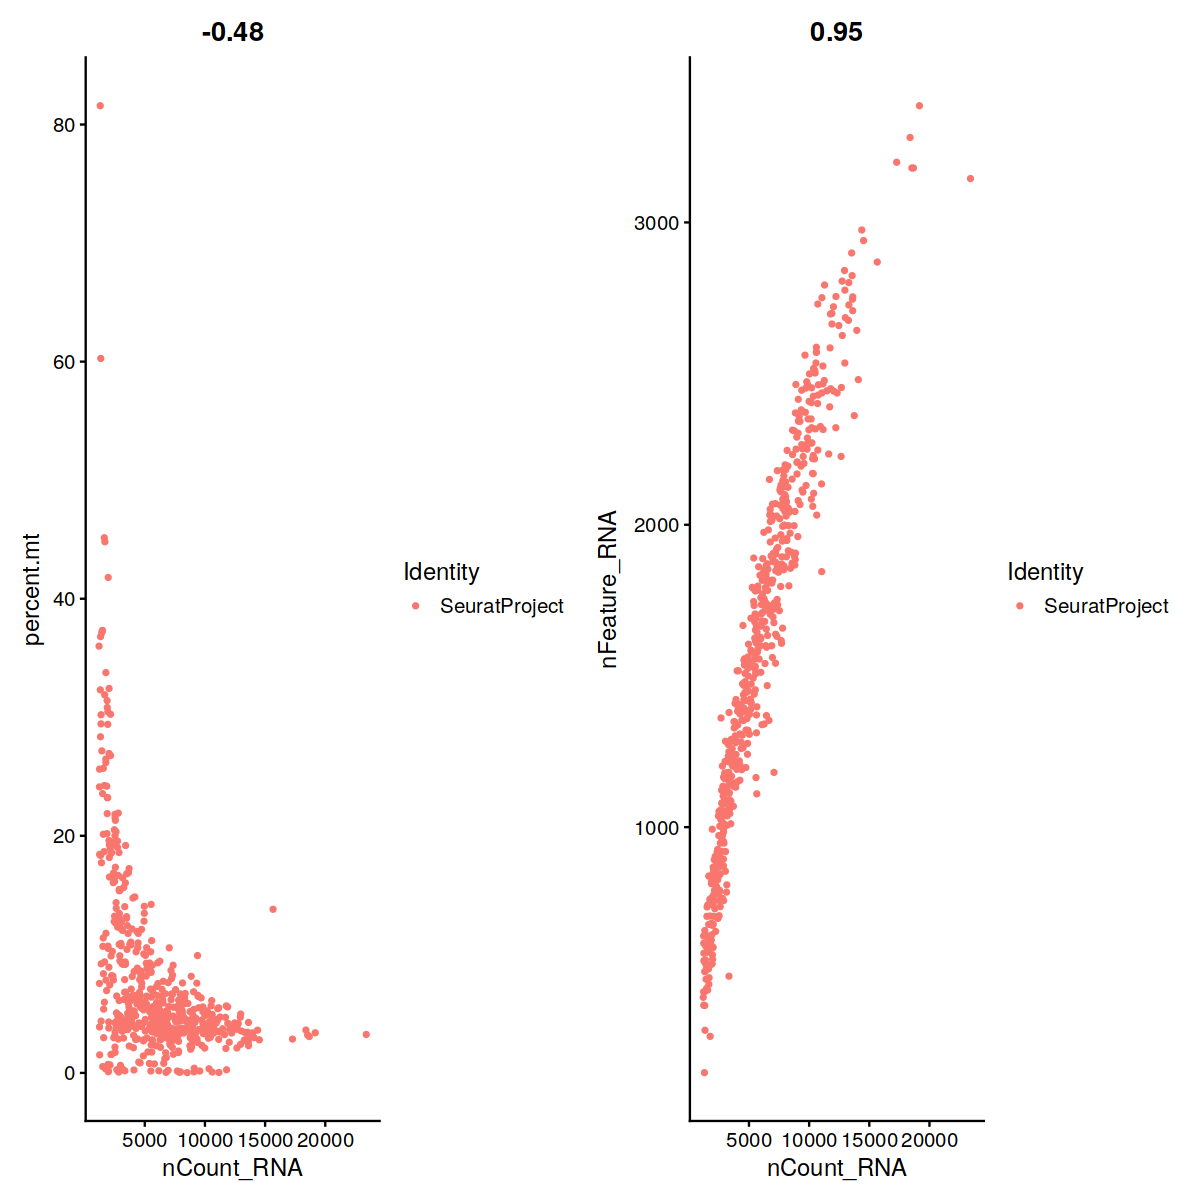

In [15]:
options(repr.plot.width=10, repr.plot.height=10)
plot1 <- FeatureScatter(matrix.list[[5]], feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(matrix.list[[5]], feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1 + plot2

Instead of eyeballing thresholds by plotting scatter plots, we could use a function to label cells as included or excluded based on our filtering thresholds without actually removing them. This way, we can get an idea of how many cells we are discarding.another if they share the same value. <br>What if we could get an idea of exactly how many cells we were discarding?<br> 

Lets use this function below to label cells that are included or excluded by our filtering thresholds without removing them:

In [16]:
label.cells <- function(Seurat.object, nFeature.high = 5000, mt.high = 25) {
  
  poscells.high.mt <- WhichCells(Seurat.object, expression = percent.mt > mt.high)
  Seurat.object$high.mt<- ifelse(colnames(Seurat.object) %in% poscells.high.mt, "Pos", "Neg")
  print("high mt cells:")
  print(table(Seurat.object$high.mt))
  
  poscells.high.ft <- WhichCells(Seurat.object, expression = nFeature_RNA > nFeature.high)
  Seurat.object$high.nFeature <- ifelse(colnames(Seurat.object) %in% poscells.high.ft, "Pos", "Neg")
  print("high nFeature cells:")
  print(table(Seurat.object$high.nFeature))
  
  return(Seurat.object)
}

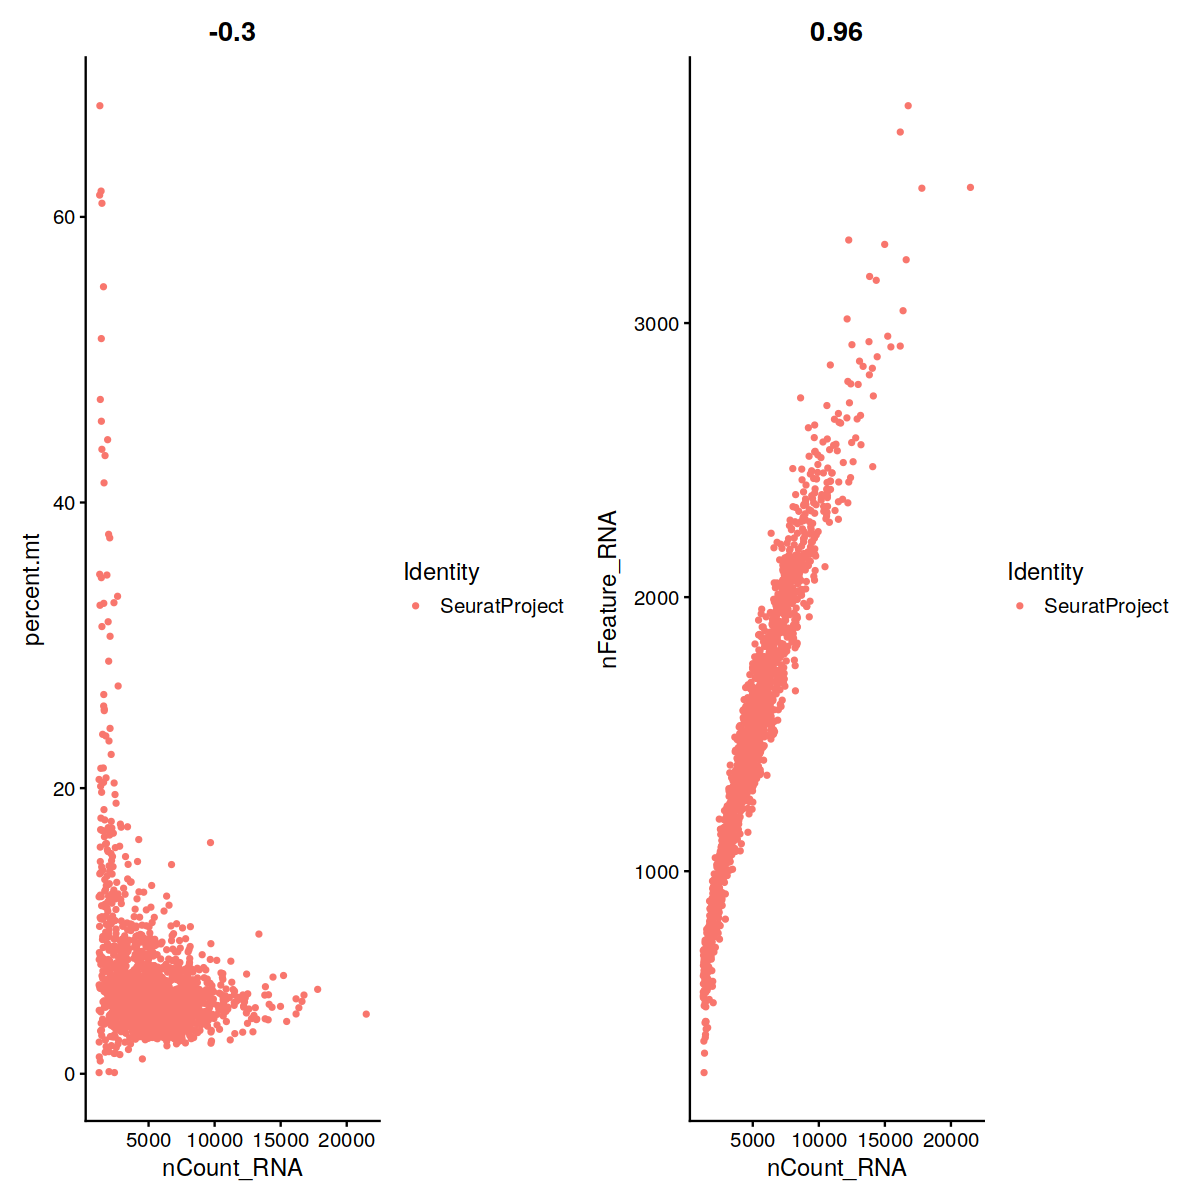

In [17]:
options(repr.plot.width=10, repr.plot.height=10)
plot1 <- FeatureScatter(matrix.list[[2]], feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(matrix.list[[2]], feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1 + plot2

In [ ]:
label.cells(matrix.list[[2]], nFeature.high = 3000, mt.high = 20)

[1] "high mt cells:"

 Neg  Pos 
1657   42 
[1] "high nFeature cells:"

 Neg  Pos 
1688   11 


An object of class Seurat 
33694 features across 1699 samples within 1 assay 
Active assay: RNA (33694 features, 0 variable features)
 1 layer present: counts

In [20]:
matrix.list[[1]] <- subset(matrix.list[[1]], subset = nFeature_RNA > 200 & nFeature_RNA < 4000 & percent.mt < 20)
matrix.list[[2]] <- subset(matrix.list[[2]], subset = nFeature_RNA > 200 & nFeature_RNA < 3000 & percent.mt < 15)
matrix.list[[3]] <- subset(matrix.list[[3]], subset = nFeature_RNA > 200 & nFeature_RNA < 4500 & percent.mt < 10)
matrix.list[[4]] <- subset(matrix.list[[4]], subset = nFeature_RNA > 200 & nFeature_RNA < 3000 & percent.mt < 10)
matrix.list[[5]] <- subset(matrix.list[[5]], subset = nFeature_RNA > 200 & nFeature_RNA < 3000 & percent.mt < 15)


We have looked at the percentage of mitochondrial reads in our cells, but there could be other signs of low quality or dying cells that we might want to filter out, such as contamination from ribosomal proteins or hemoglobin.


In [21]:
matrix.list <- lapply(matrix.list, function(object) {
  object[["percent.ribo"]] <- PercentageFeatureSet(object, pattern = "^RP[SL]")
  object
})

matrix.list <- lapply(matrix.list, function(object) {
  object[["percent.hb"]] <- PercentageFeatureSet(object, pattern = "^HB[^(P)]")
  object
})

We can access all the QC metrics we have calculated in our data within the meta.data slot in our Seurat object:

In [22]:
head(matrix.list[[1]]@meta.data, 5)

orig.ident    nCount_RNA nFeature_RNA Sample Group  
AAACCTGAGACTCGGA-1 SeuratProject 7175       2039         HC0701 Healthy
AAACCTGCACCCAGTG-1 SeuratProject 3602       1332         HC0701 Healthy
AAACCTGTCAGTGTTG-1 SeuratProject 1509        606         HC0701 Healthy
AAACGGGAGATCCGAG-1 SeuratProject 4199       1491         HC0701 Healthy
AAACGGGAGCCGGTAA-1 SeuratProject 1844        867         HC0701 Healthy
                   percent.mt percent.ribo percent.hb
AAACCTGAGACTCGGA-1  4.445993  15.20557     0.00000000
AAACCTGCACCCAGTG-1  5.746807  12.74292     0.00000000
AAACCTGTCAGTGTTG-1 12.988734  18.82041     0.00000000
AAACGGGAGATCCGAG-1  6.620624  14.78924     0.02381519
AAACGGGAGCCGGTAA-1  6.778742  12.79826     0.00000000

## Data Normalisation

After filtering our data, we normalize it to make sure expression counts are comparable across genes and samples. This adjustment corrects for variability introduced during the sequencing process, ensuring that observed gene expression differences reflect biology rather than technical factors.

There are different types of normalization techniques available like SCT Log Normalization here we will use the LogNormalize function on our data

In [24]:
matrix.list <- lapply(X = matrix.list, FUN = function(x) {
    x <- NormalizeData(x)
})

Normalizing layer: counts

Normalizing layer: counts

Normalizing layer: counts

Normalizing layer: counts

Normalizing layer: counts



### Cell Cycle Scoring

After normalization, we analyze cell cycle genes to adjust for variation due to cell cycle stages in our single-cell data. The Seurat package includes a list of these genes (cc.genes) to help identify cells in the S, G2M, or G1 phase.

In [25]:
s.genes <- cc.genes$s.genes
g2m.genes <- cc.genes$g2m.genes

In [26]:
cc.genes

$s.genes
 [1] "MCM5"     "PCNA"     "TYMS"     "FEN1"     "MCM2"     "MCM4"    
 [7] "RRM1"     "UNG"      "GINS2"    "MCM6"     "CDCA7"    "DTL"     
[13] "PRIM1"    "UHRF1"    "MLF1IP"   "HELLS"    "RFC2"     "RPA2"    
[19] "NASP"     "RAD51AP1" "GMNN"     "WDR76"    "SLBP"     "CCNE2"   
[25] "UBR7"     "POLD3"    "MSH2"     "ATAD2"    "RAD51"    "RRM2"    
[31] "CDC45"    "CDC6"     "EXO1"     "TIPIN"    "DSCC1"    "BLM"     
[37] "CASP8AP2" "USP1"     "CLSPN"    "POLA1"    "CHAF1B"   "BRIP1"   
[43] "E2F8"    

$g2m.genes
 [1] "HMGB2"   "CDK1"    "NUSAP1"  "UBE2C"   "BIRC5"   "TPX2"    "TOP2A"  
 [8] "NDC80"   "CKS2"    "NUF2"    "CKS1B"   "MKI67"   "TMPO"    "CENPF"  
[15] "TACC3"   "FAM64A"  "SMC4"    "CCNB2"   "CKAP2L"  "CKAP2"   "AURKB"  
[22] "BUB1"    "KIF11"   "ANP32E"  "TUBB4B"  "GTSE1"   "KIF20B"  "HJURP"  
[29] "CDCA3"   "HN1"     "CDC20"   "TTK"     "CDC25C"  "KIF2C"   "RANGAP1"
[36] "NCAPD2"  "DLGAP5"  "CDCA2"   "CDCA8"   "ECT2"    "KIF23"   "HMMR"   
[43] "AURKA"   "PSRC1"   "ANLN"    "LBR"     "CKAP5"   "CENPE"   "CTCF"   
[50] "NEK2"    "G2E3"    "GAS2L3"  "CBX5"    "CENPA"

In [27]:
matrix.list <- lapply(X = matrix.list, FUN = function(x) {
    x <- CellCycleScoring(x, s.features = s.genes, g2m.features = g2m.genes)
})

Warning message:
“The following features are not present in the object: MLF1IP, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: MLF1IP, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: MLF1IP, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: MLF1IP, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: MLF1IP, not searching for symbol synonyms”


## Feature Selection

After normalization, we choose the most informative genes that explain the bulk of the variation in our dataset, disregarding those with zero counts, which don't provide meaningful insights due to technical drop-out in single-cell RNA sequencing.

In [28]:
# normalize and identify variable features for each dataset independently
matrix.list <- lapply(X = matrix.list, FUN = function(x) {
    x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = 2000)
})

Finding variable features for layer counts

Finding variable features for layer counts

Finding variable features for layer counts

Finding variable features for layer counts

Finding variable features for layer counts



When using repel, set xnudge and ynudge to 0 for optimal results

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”


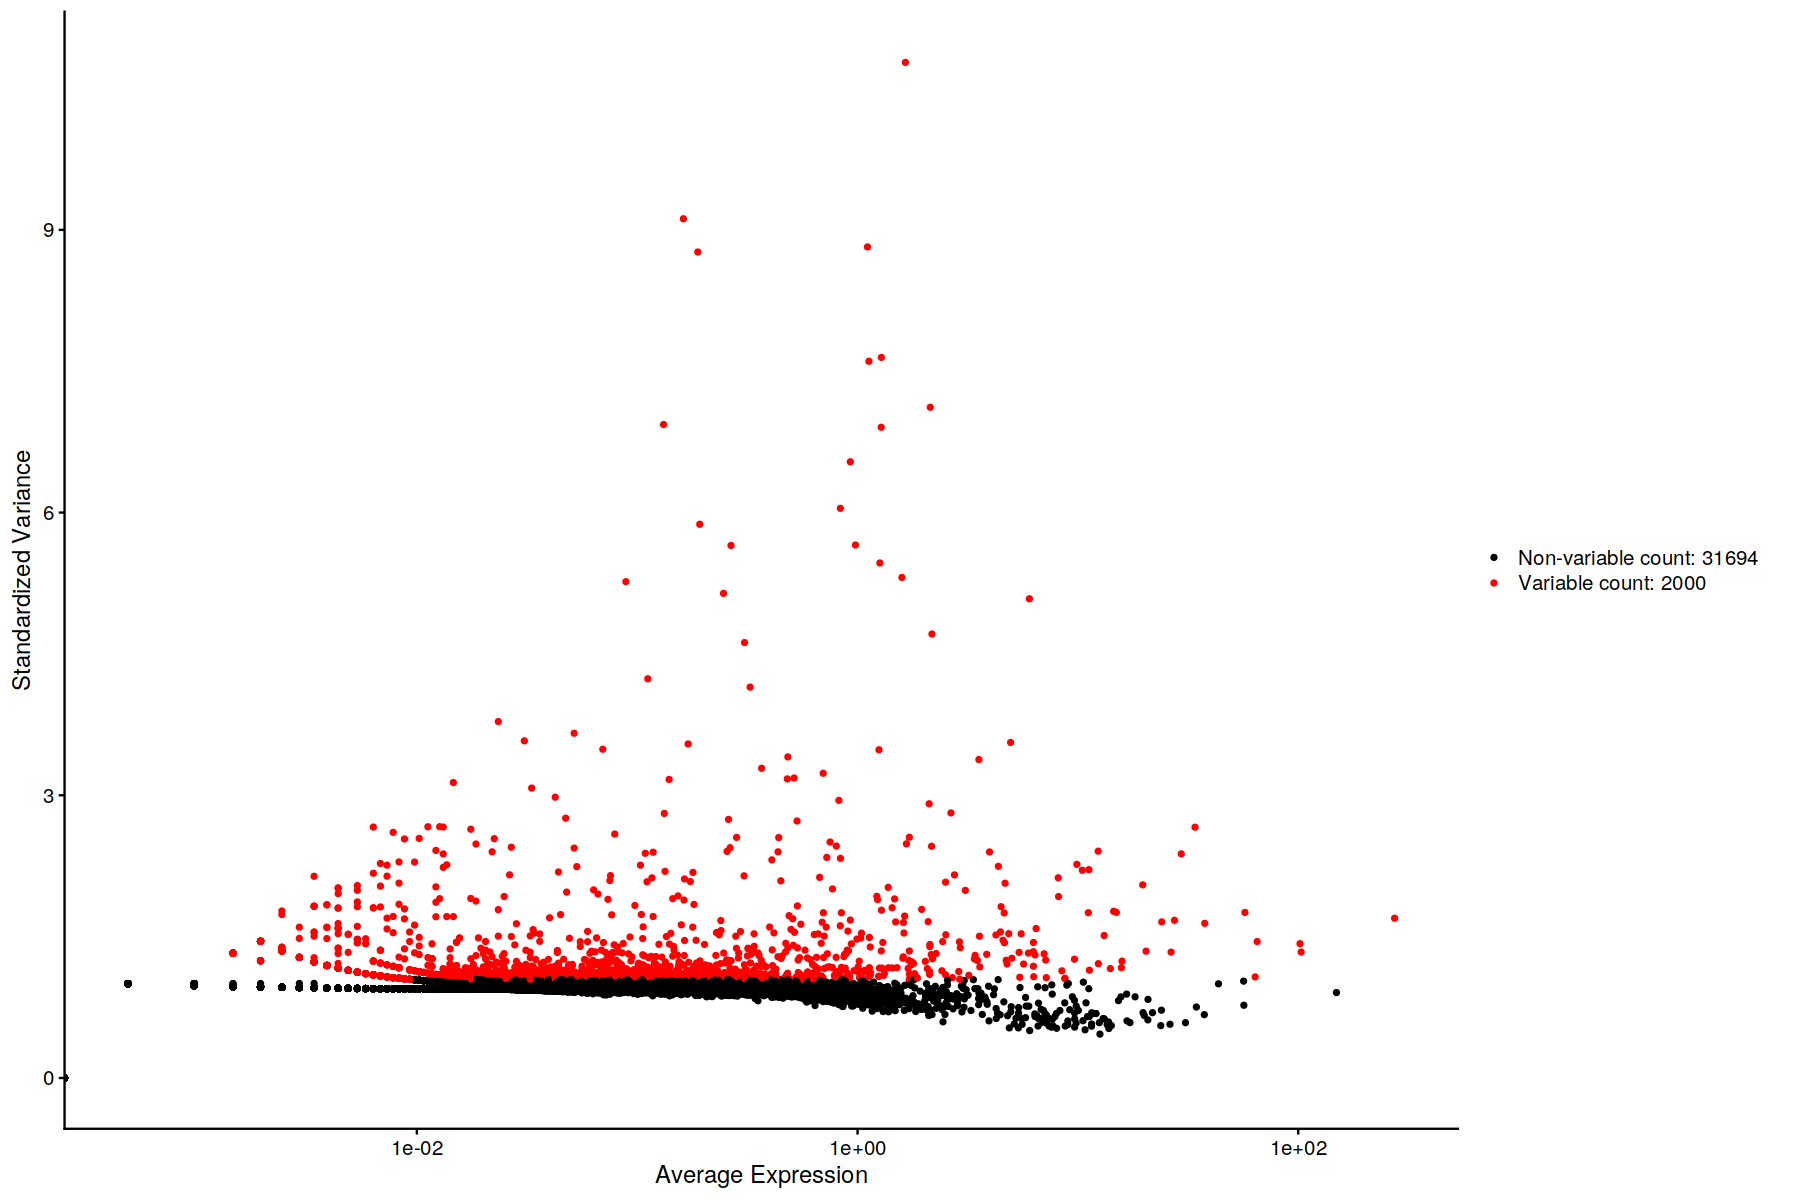

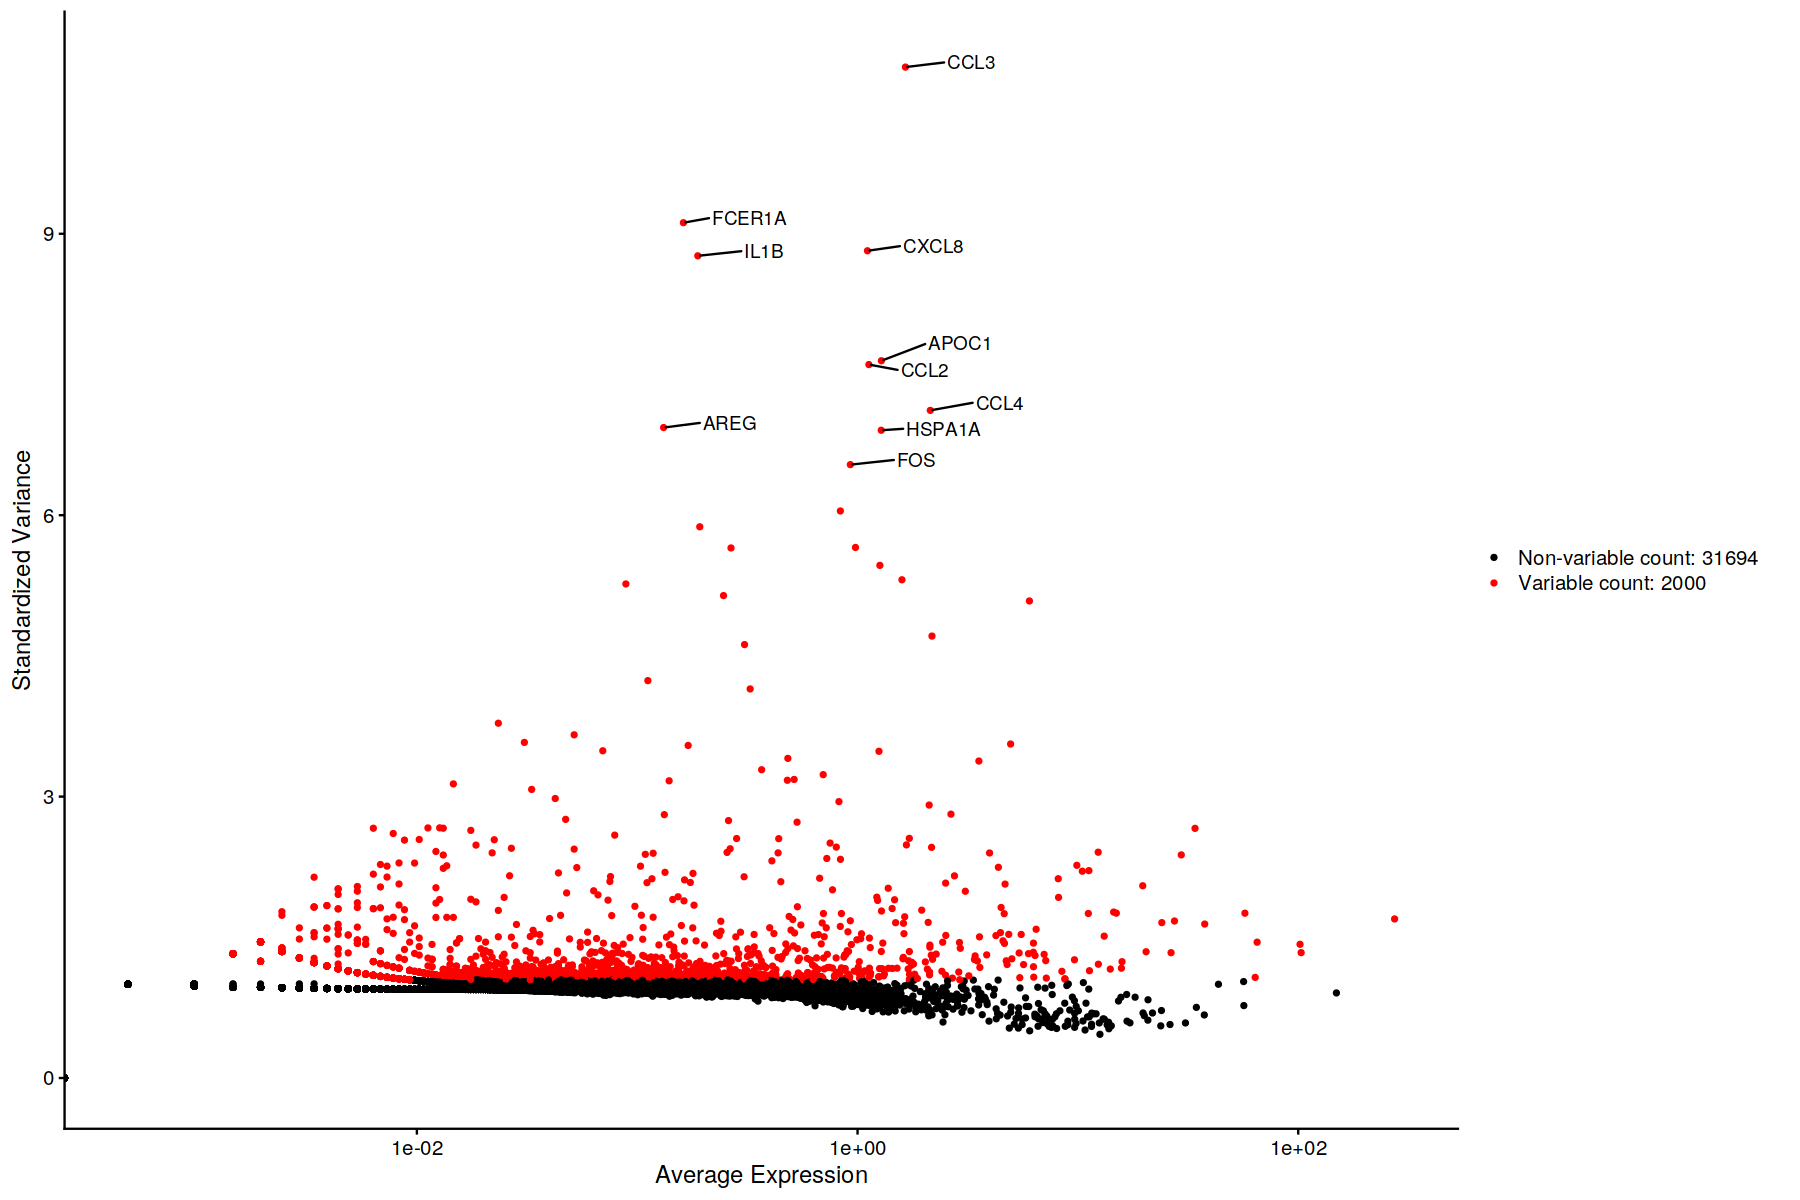

In [30]:
options(repr.plot.width=15, repr.plot.height=10)
# Identify the 10 most highly variable genes
plot1 <- VariableFeaturePlot(matrix.list[[1]])
top10 <- head(VariableFeatures(matrix.list[[1]]), 10)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
plot1 
plot2

### Seurat CCA integration


We will integrate our data using Seurat's CCA method to remove batch effects. This method creates a new 'integrated' assay by reducing dimensions and generating a corrected matrix based on gene-gene correlations. Alternatively, we can use other methods like Harmony, depending on analysis needs and experimental design.

We integrate our datasets using anchored cells in the same biological state to identify shared cell types across different datasets, removing batch effects that might have caused separation.



In [31]:
features <- SelectIntegrationFeatures(object.list = matrix.list)

In [ ]:
data.anchors <- FindIntegrationAnchors(object.list = matrix.list, anchor.features = features)

In [ ]:
combined <- IntegrateData(anchorset = data.anchors)

### Scaling scRNA data
After integration, we scale our data. Scaling is crucial before reducing dataset dimensionality. It is a linear transformation ensuring equal weight for all genes, preventing highly expressing genes from dominating downstream analyses.

In [34]:
# Run the standard workflow for visualization and clustering
combined <- ScaleData(combined, vars.to.regress = "percent.mt")

Regressing out percent.mt

Centering and scaling data matrix



### PCA (Principal Component Analysis)


In single cell RNA sequencing, each cell's gene expression creates a high dimensional space that is hard to visualize. To simplify and capture the dataset's variation, we use PCA. PCA creates uncorrelated variables, called principal components, reducing the data into a lower dimensional space.

By plotting the elbow plot, we can determine how much variation each principal component explains. This helps us prevent adding noise to the data.

In [35]:
combined <- RunPCA(combined, npcs = 50, verbose = FALSE)

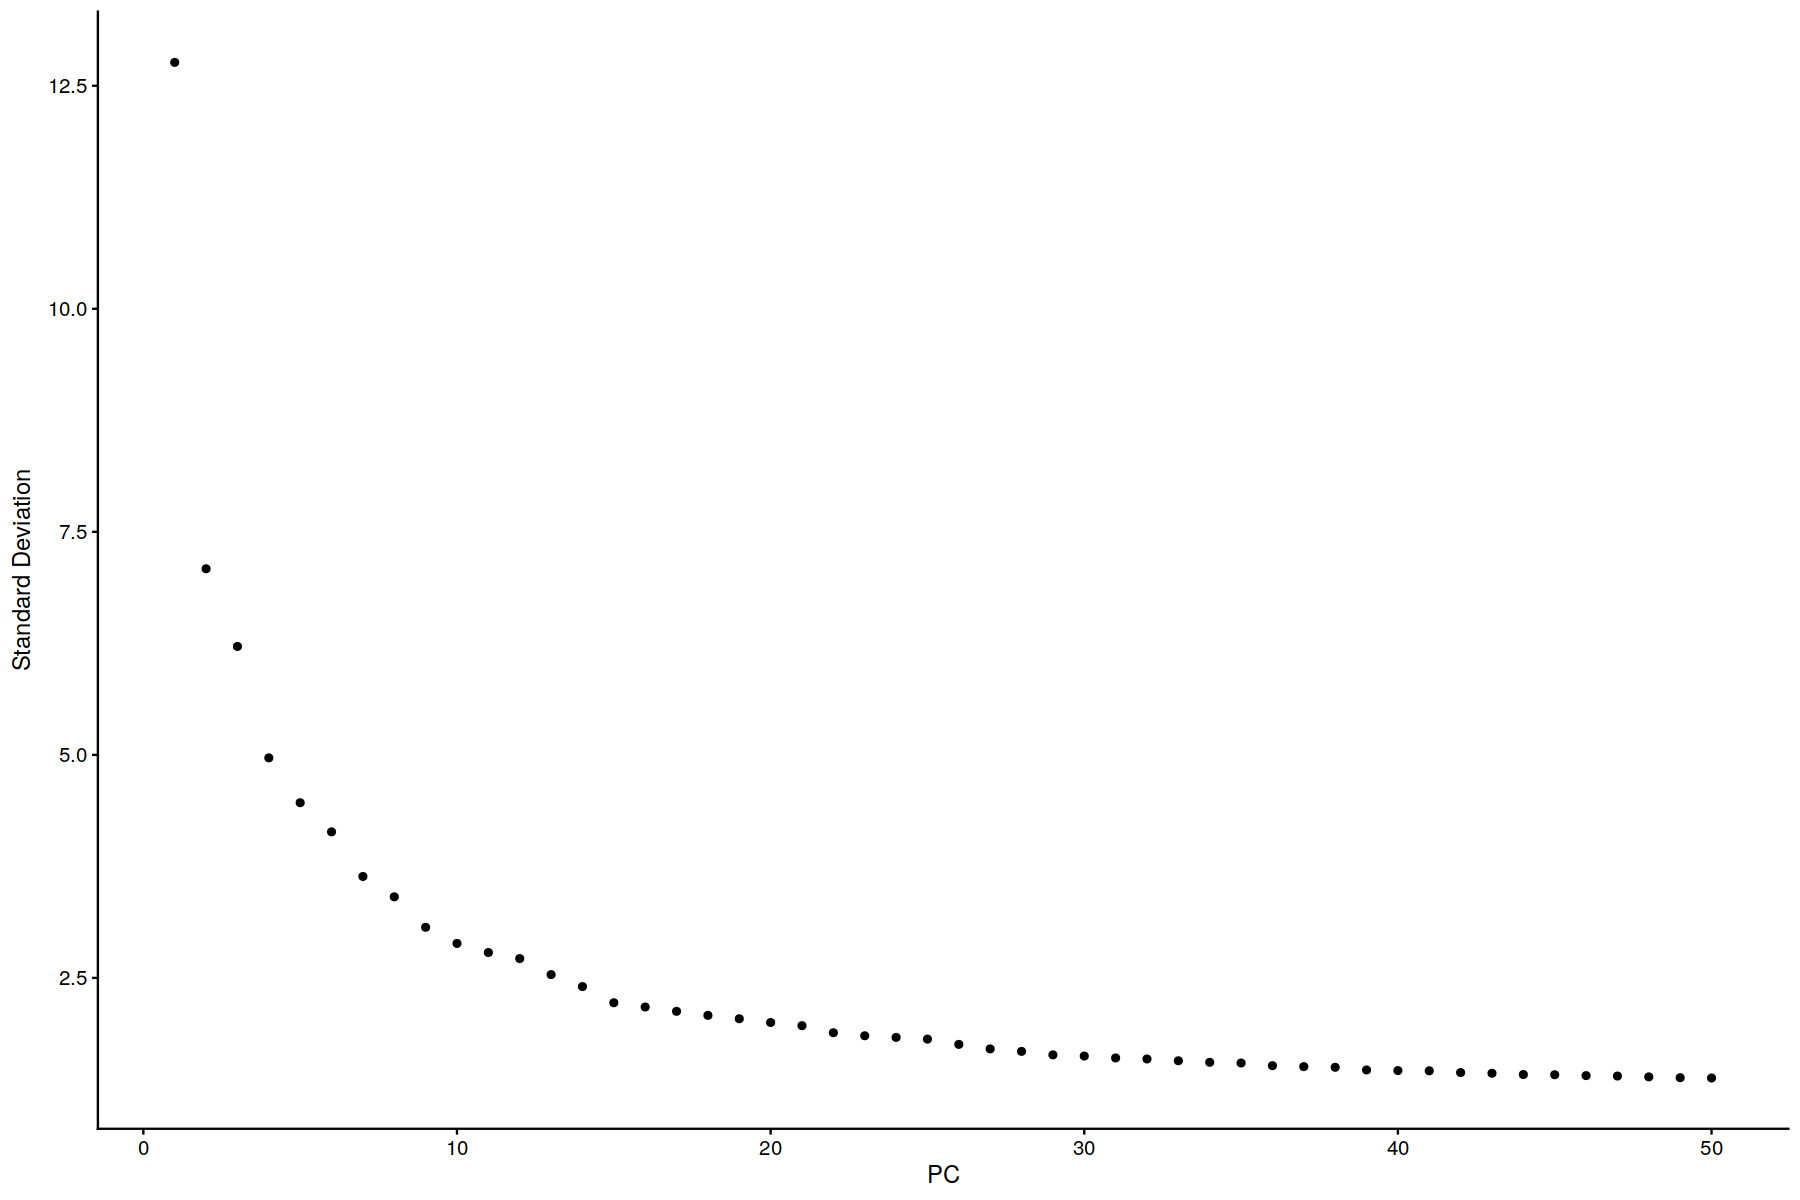

In [36]:
ElbowPlot(combined, ndims=50)

### Running UMAP and Neighbourhoods
After performing dimensionality reduction, we can explore the structure of our data in a low dimensional space by embedding our cells within a UMAP space.

In [ ]:
combined <- RunUMAP(combined, reduction = "pca", dims = 1:30)
combined <- FindNeighbors(combined, reduction = "pca", dims = 1:30)

### Finding our clusters

The resolution parameter can dictate the granularity of our clustering, just like the resolution on a picture with a higher resolution making the image more crisp and a lower resolution being more blurry. We need to use out biological knowlege to choose an appropriate resolution to cluster our data however we can run clustering on a range of resolutions and use the clustree package to help us choose an appropriate value for this parameter:

In [38]:
# Select a range of resolutions
resolution.range <- seq(from = 0, to = 1, by = 0.1)

# Find clusters using a range of resolutions
combined <- FindClusters(object = combined, resolution = resolution.range)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 10779
Number of edges: 405320

Running Louvain algorithm...
Maximum modularity in 10 random starts: 1.0000
Number of communities: 2
Elapsed time: 4 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 10779
Number of edges: 405320

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9542
Number of communities: 9
Elapsed time: 3 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 10779
Number of edges: 405320

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9244
Number of communities: 11
Elapsed time: 3 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 10779
Number of edges: 405320

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9029
Number of communities: 12
Elapsed time: 3 seconds
Modularity Opt

## Clustree
Tools like clustree try to help us recognize overclustering, but they can be tricky to interpret for complex datasets like single-cell RNA sequencing. The basic idea is that if a node has lots of branches coming off it, it might mean we've divided our data into too many clusters.

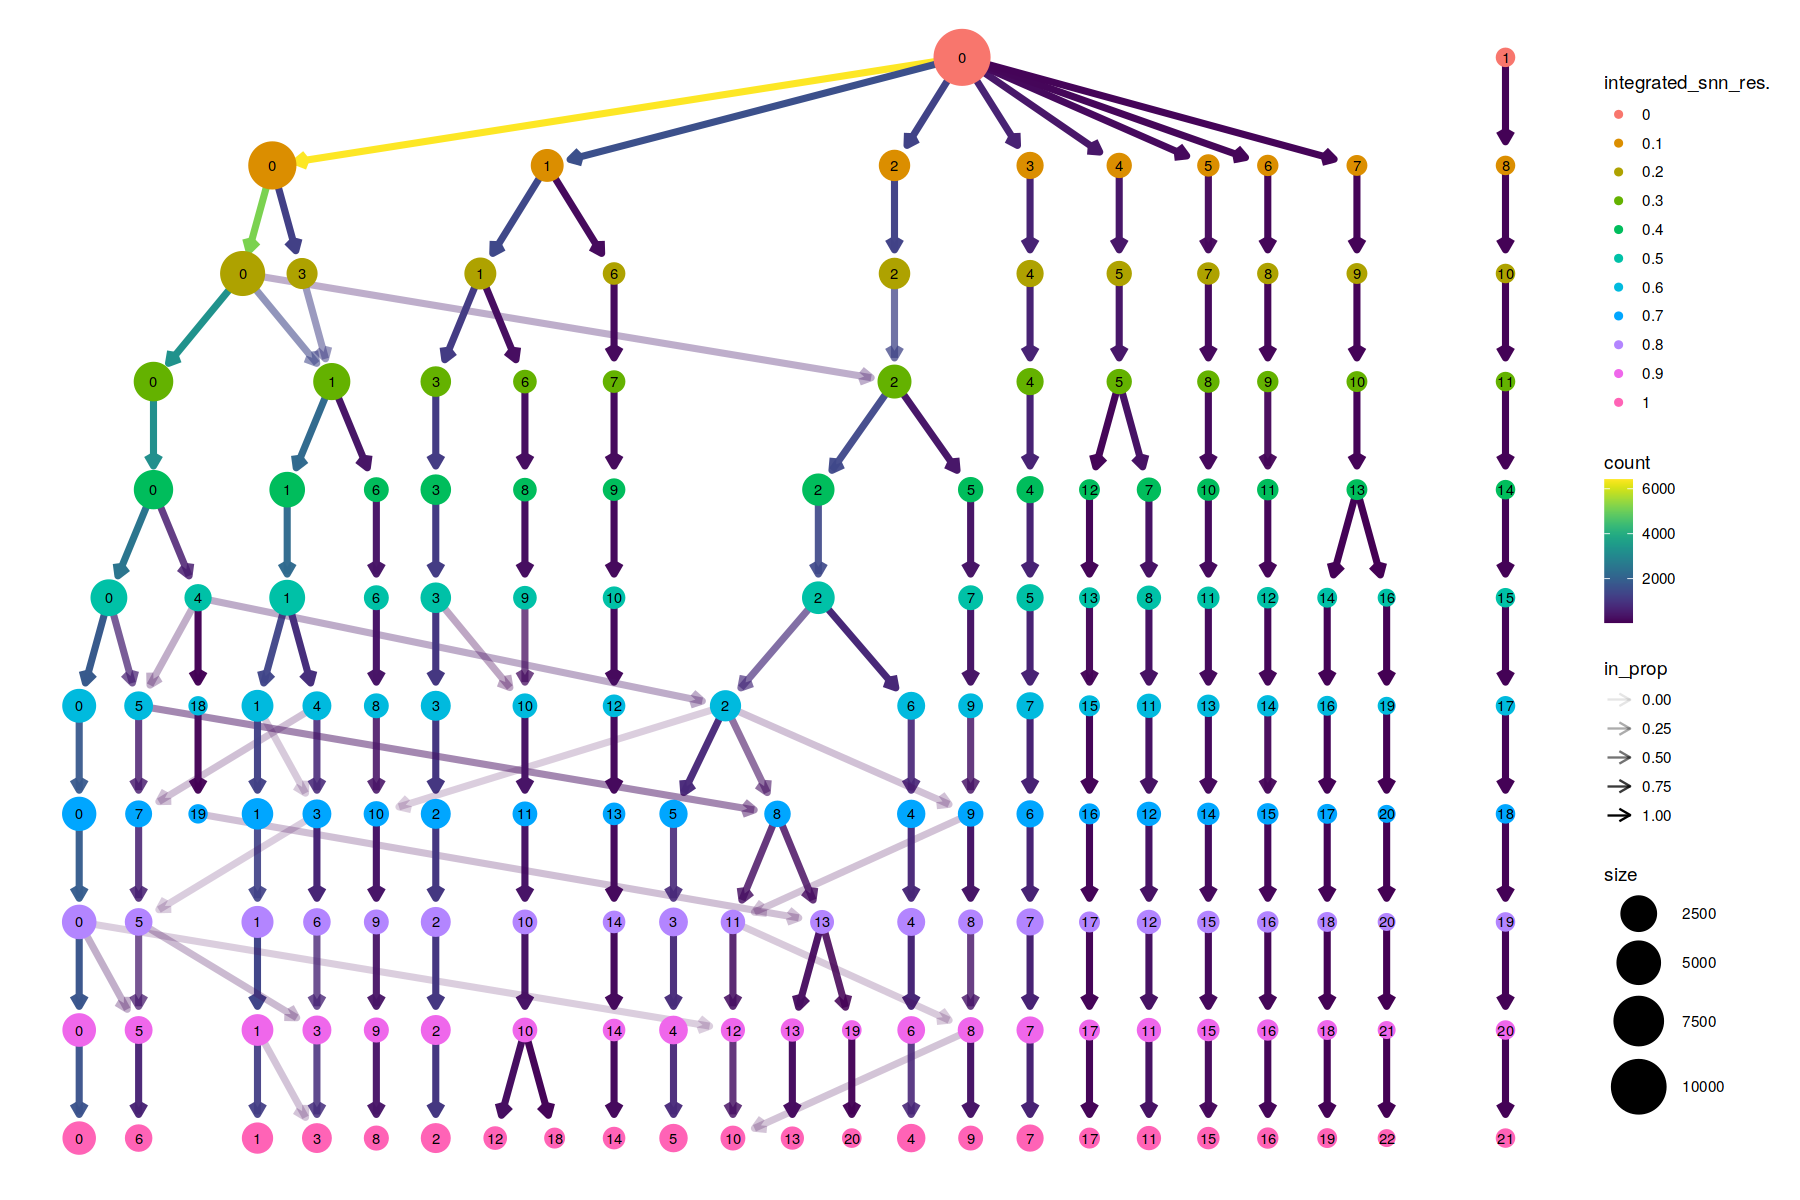

In [39]:
clustree(combined)

In [41]:
# Find clusters using a range of resolutions
Idents(combined) <- combined$`integrated_snn_res.0.5`

Once we have determined the cluster resolution, we can visualize the clusters. We plot the UMAP using Seurat clustering and observe different clusters based on disease groups. And also we can split out the UMAP based on disease.

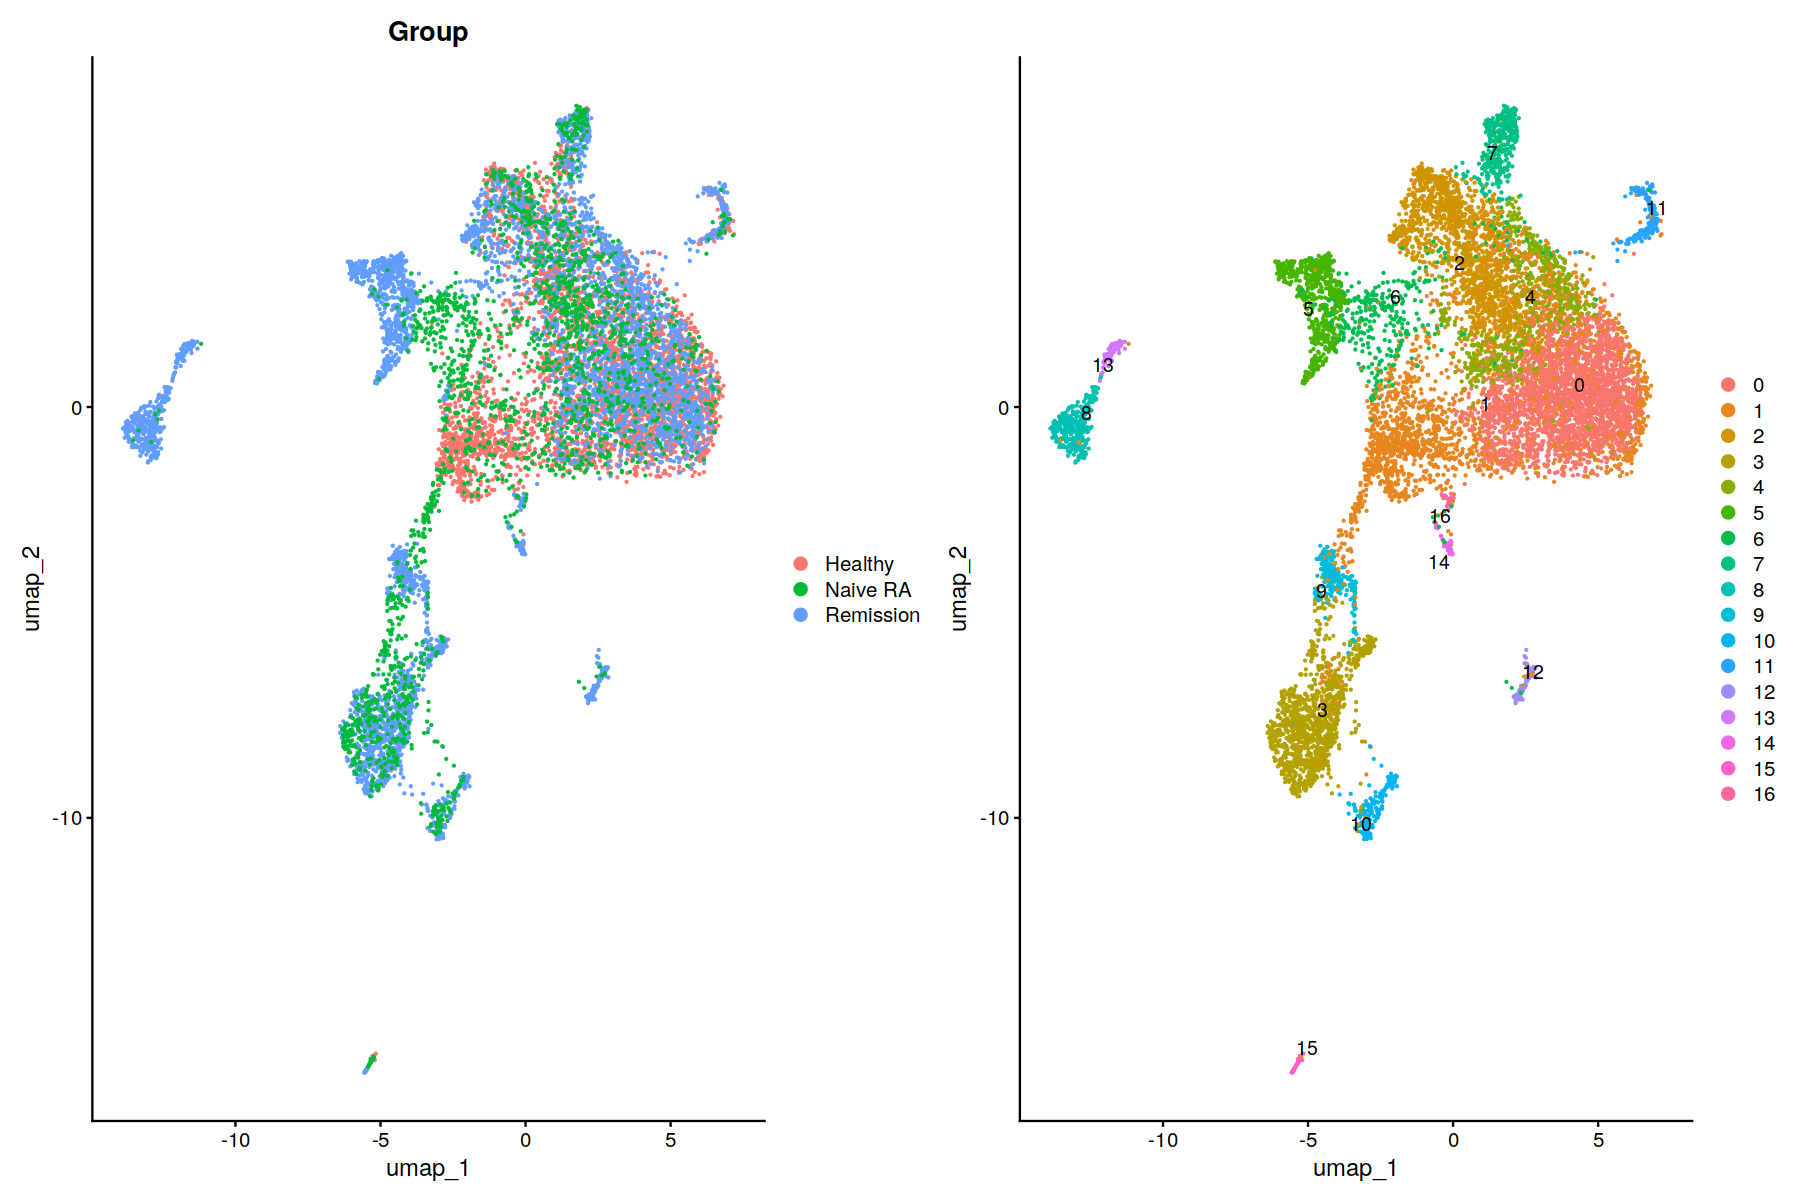

In [42]:
options(repr.plot.width=15, repr.plot.height=10)
p1 <- DimPlot(combined, reduction = "umap", group.by = "Group")
p2 <- DimPlot(combined, reduction = "umap", label = TRUE, repel = TRUE)
p1 + p2

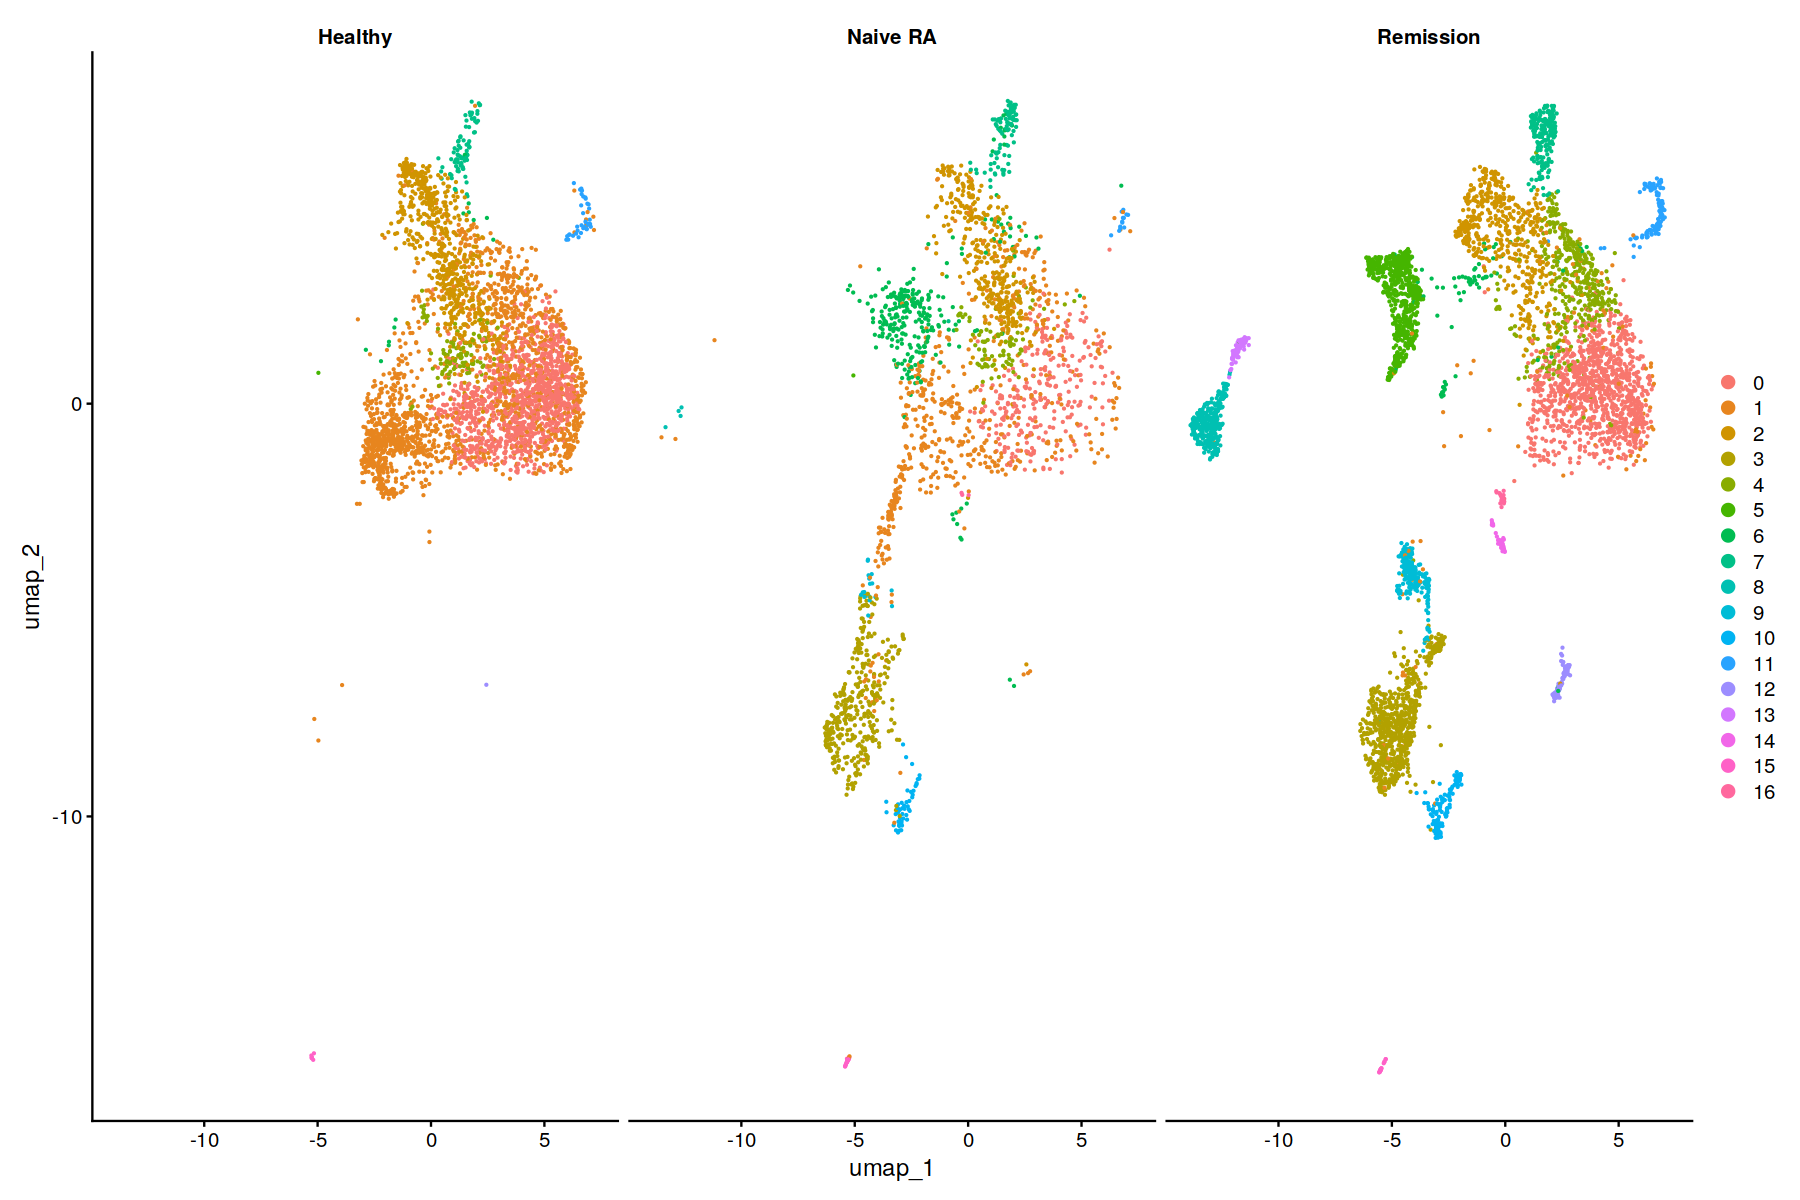

In [43]:
p3 <- DimPlot(combined, reduction = "umap", split.by = "Group")
p3

Observing UMAP plot it seems that certain cell populations are exclusive to specific disease groups. To identify these cell types, we can use FindAllMarkers, which reveals genes differentially expressed in a particular cluster compared to all other clusters in our data.

In [51]:
combined <- JoinLayers(combined)
DefaultAssay(combined) <- "RNA"

combined.markers <- FindAllMarkers(combined, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25, test.use = "wilcox")
combined.markers

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15

Calculating cluster 16



p_val       avg_log2FC pct.1 pct.2 p_val_adj cluster gene   
ALDH1A1  0           1.8214428  0.752 0.241 0         0       ALDH1A1
FOLR2    0           1.4174156  0.916 0.408 0         0       FOLR2  
C1QC     0           1.3840765  0.994 0.512 0         0       C1QC   
MS4A4A   0           1.4248475  0.843 0.388 0         0       MS4A4A 
FCGR3A   0           1.5730440  0.926 0.475 0         0       FCGR3A 
C1QB     0           1.7778627  0.998 0.567 0         0       C1QB   
MARCO    0           1.4154261  0.960 0.544 0         0       MARCO  
TREM2    0           1.4825763  0.694 0.283 0         0       TREM2  
C1QA     0           1.5109437  1.000 0.603 0         0       C1QA   
NUPR1    0           1.4911534  0.918 0.523 0         0       NUPR1  
VSIG4    0           1.1911885  0.919 0.525 0         0       VSIG4  
MS4A6A   0           0.9593857  0.975 0.600 0         0       MS4A6A 
LGMN     0           1.2535731  0.912 0.566 0         0       LGMN   
APOC1    0           2.1640430  0.718 0.379 0         0       APOC1  
RNASE1   0           1.4223927  1.000 0.669 0         0       RNASE1 
ASAH1    0           1.2289403  0.899 0.588 0         0       ASAH1  
AIF1     0           0.9521847  0.998 0.692 0         0       AIF1   
GPNMB    0           1.1378013  0.929 0.624 0         0       GPNMB  
VAMP8    0           0.9823804  0.977 0.677 0         0       VAMP8  
CTSZ     0           1.0334765  0.958 0.659 0         0       CTSZ   
CD68     0           1.0339742  0.964 0.699 0         0       CD68   
CTSS     0           0.9694070  0.979 0.730 0         0       CTSS   
GLUL     0           1.1405973  0.966 0.740 0         0       GLUL   
CTSD     0           1.0711198  0.958 0.743 0         0       CTSD   
CTSB     0           0.8771213  0.990 0.826 0         0       CTSB   
GPX1     0           0.8564977  0.987 0.862 0         0       GPX1   
NPC2     0           0.8691775  1.000 0.914 0         0       NPC2   
PSAP     0           0.7181300  0.999 0.936 0         0       PSAP   
FTL      0           1.4496274  1.000 0.999 0         0       FTL    
TMSB4X   0           0.6963082  1.000 1.000 0         0       TMSB4X 
⋮        ⋮           ⋮          ⋮     ⋮     ⋮         ⋮       ⋮      
PINK13   0.002429703 0.8599501  0.294 0.112 1         16      PINK1  
ODF3B2   0.002535752 0.5766131  0.412 0.173 1         16      ODF3B  
CSF2RB   0.003011070 0.6484636  0.265 0.098 1         16      CSF2RB 
MBNL2    0.003044017 0.7771892  0.265 0.098 1         16      MBNL2  
ORAI2    0.003147290 0.3335268  0.294 0.111 1         16      ORAI2  
H2AFX4   0.003349688 0.6142121  0.382 0.165 1         16      H2AFX  
DDOST6   0.003654542 0.5340627  0.588 0.290 1         16      DDOST  
GOLGA31  0.003665995 1.2375450  0.265 0.100 1         16      GOLGA3 
NAE13    0.003912406 0.5082361  0.294 0.115 1         16      NAE1   
PACSIN22 0.004503807 1.0594521  0.294 0.126 1         16      PACSIN2
TRABD3   0.004556553 0.6153199  0.382 0.163 1         16      TRABD  
PHF11    0.004601227 0.5044992  0.294 0.116 1         16      PHF1   
WIPI1    0.004650981 0.3115349  0.324 0.129 1         16      WIPI1  
ZNF7911  0.004723479 0.5285125  0.294 0.118 1         16      ZNF791 
SCYL11   0.005706368 0.3834286  0.294 0.117 1         16      SCYL1  
NFKB21   0.005769192 0.2889474  0.265 0.102 1         16      NFKB2  
TAF101   0.006391555 0.6533063  0.265 0.104 1         16      TAF10  
ALG21    0.006434067 0.6539660  0.294 0.120 1         16      ALG2   
LILRB1   0.006513828 1.7201056  0.265 0.109 1         16      LILRB1 
LRRC595  0.006876030 0.4511158  0.500 0.245 1         16      LRRC59 
PYCR21   0.007321431 0.3351169  0.294 0.119 1         16      PYCR2  
ST8SIA41 0.007337438 0.5650952  0.324 0.141 1         16      ST8SIA4
ITGB3BP2 0.007452206 0.5163620  0.294 0.121 1         16      ITGB3BP
KRTCAP23 0.007511211 0.4545285  0.882 0.526 1         16      KRTCAP2
C21orf21 0.007827228 0.4497609  0.294 0.123 1         16      C21orf2
PDXK4    0.00824640

In [59]:
Assays(combined)

[1] "RNA"        "integrated"

In [ ]:
top.combined.markers <- combined.markers %>%
    group_by(cluster) %>%
    slice_max(n = 10, order_by = avg_log2FC)
top.combined.markers

In [ ]:
DefaultAssay(combined) <- "RNA"
DoHeatmap(combined,  features = as.character(top.combined.markers$gene)) 


#### Cluster annotation
Instead of labelling all the clusters in the dataset we are going to try and replicate the key findings from the RA macrophage paper: https://www.nature.com/articles/s41591-020-0939-8

We will analyze Figure 2, focusing on synovial tissue macrophage subsets. Initially, we'll identify MERTK-positive and MERTK-negative populations.

Then, we will plot MERTK expression to find MERTK-positive populations and CD48 expression for MERTK-negative clusters.

Next, we willlook at MERTK-negative subsets expressing S100A12, SPP1, and CLEC10A, creating a new subset named after these markers.

Following that, we'll find two MERTK-positive subsets within the MERTK-positive cluster, using LYVE1 and TREM2 expression to distinguish them.

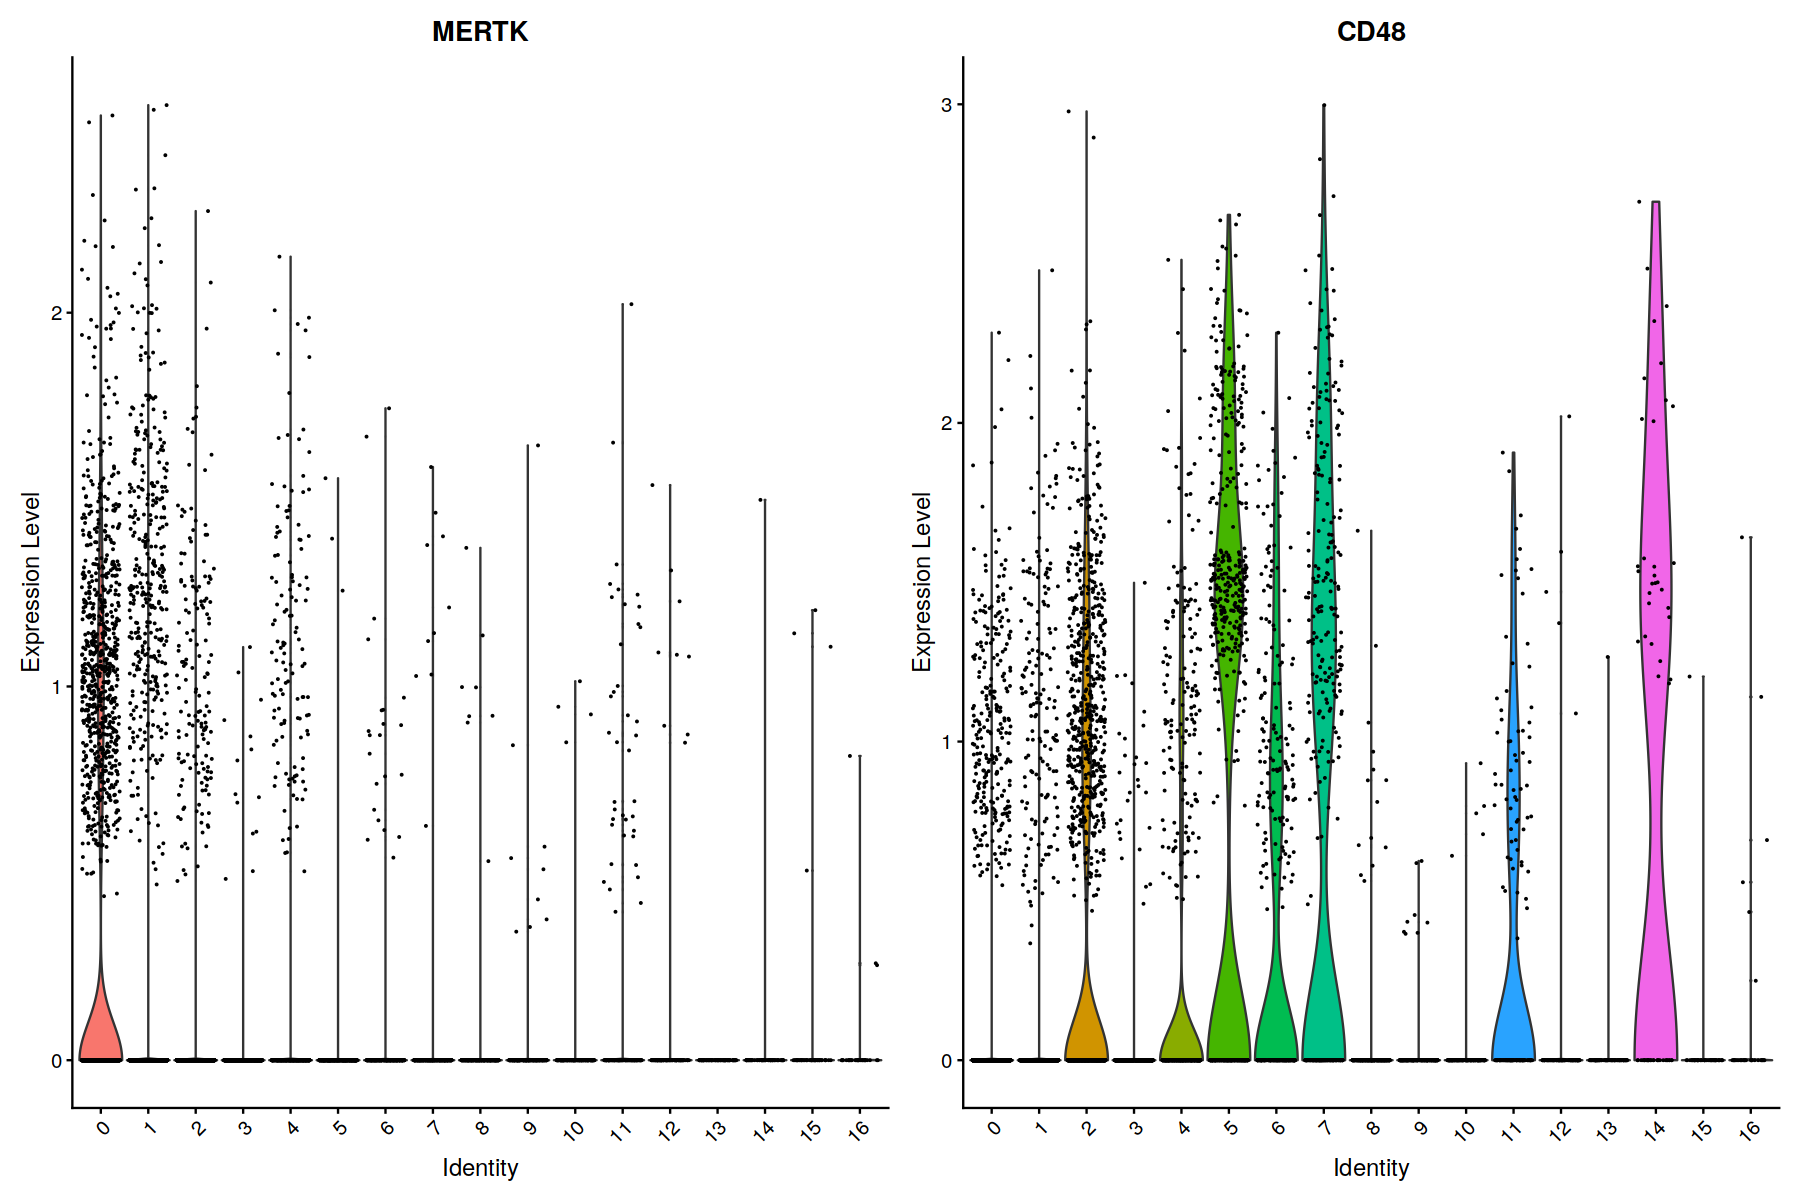

In [66]:
VlnPlot(combined, features = c("MERTK", "CD48"))

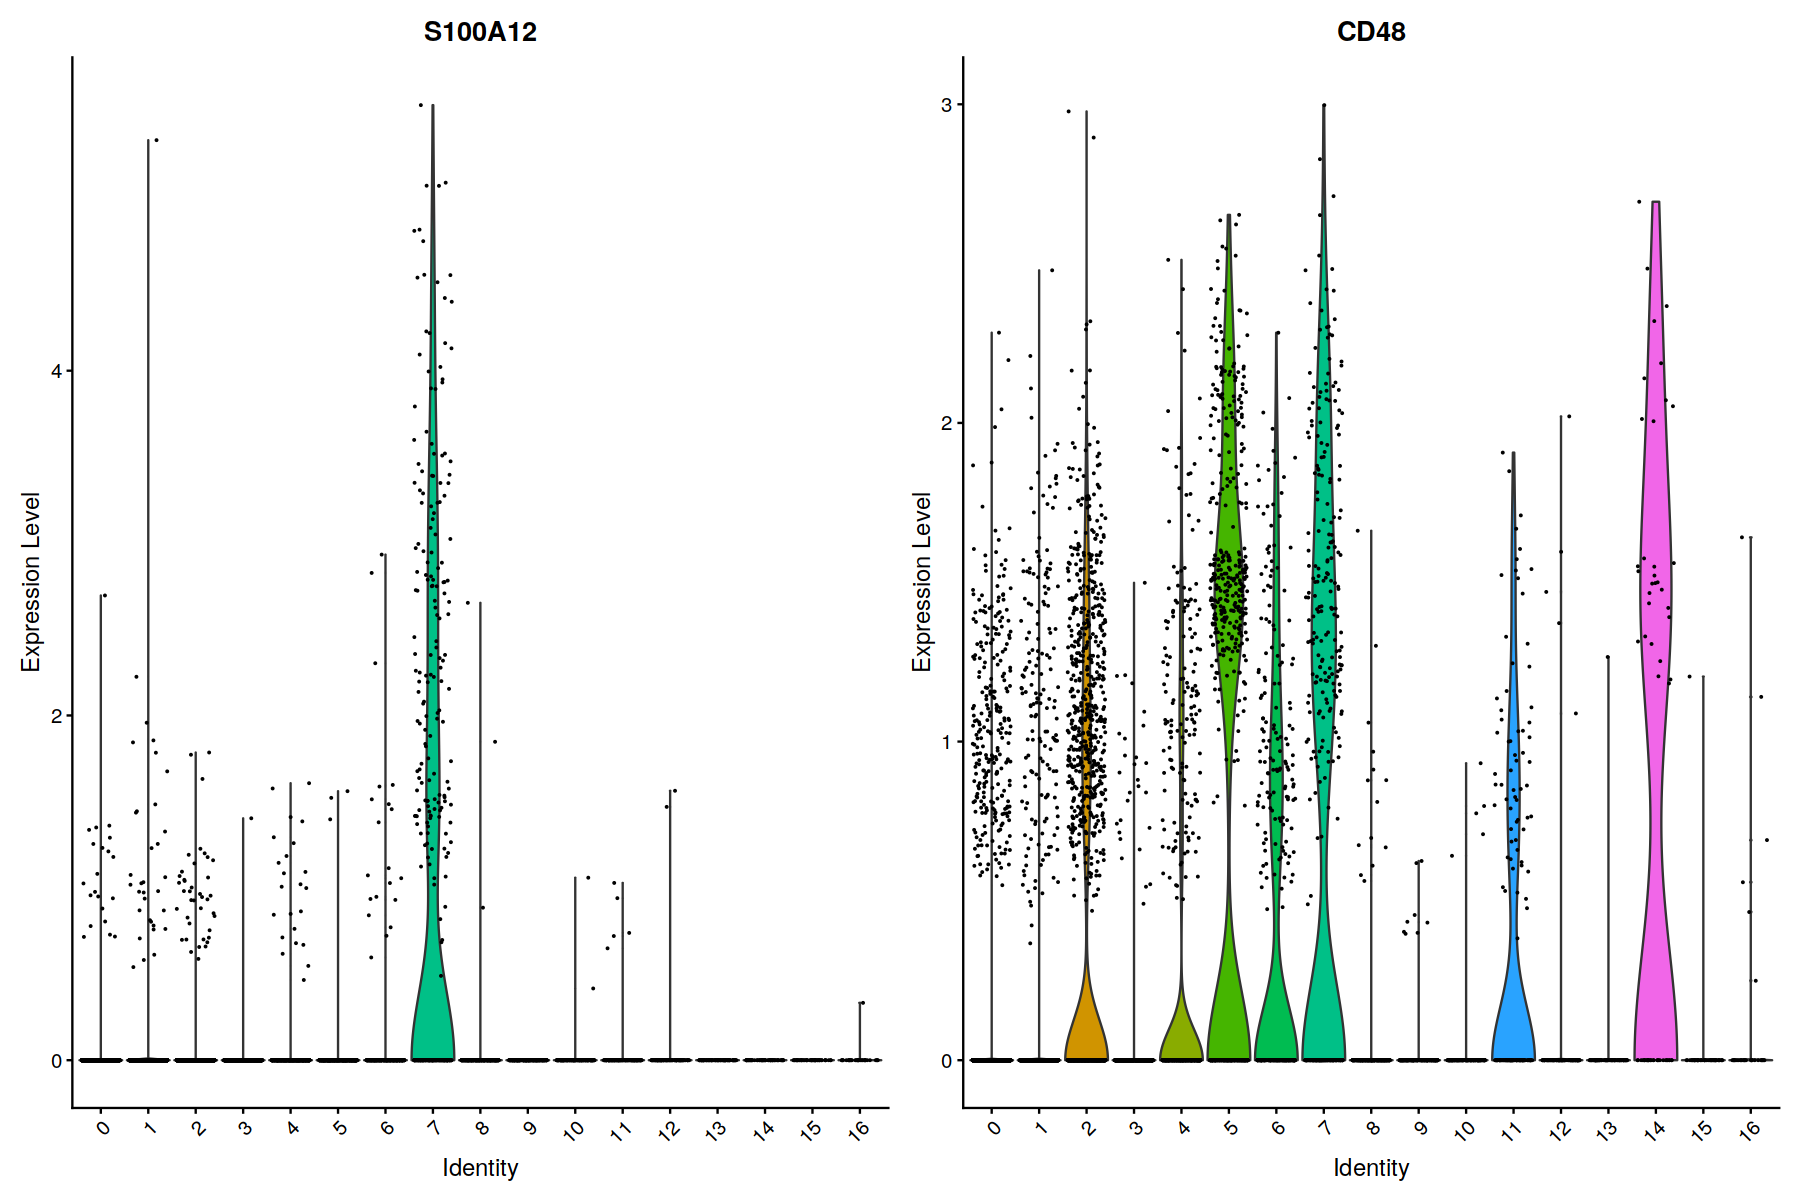

In [67]:
VlnPlot(combined, features = c("S100A12", "CD48"))

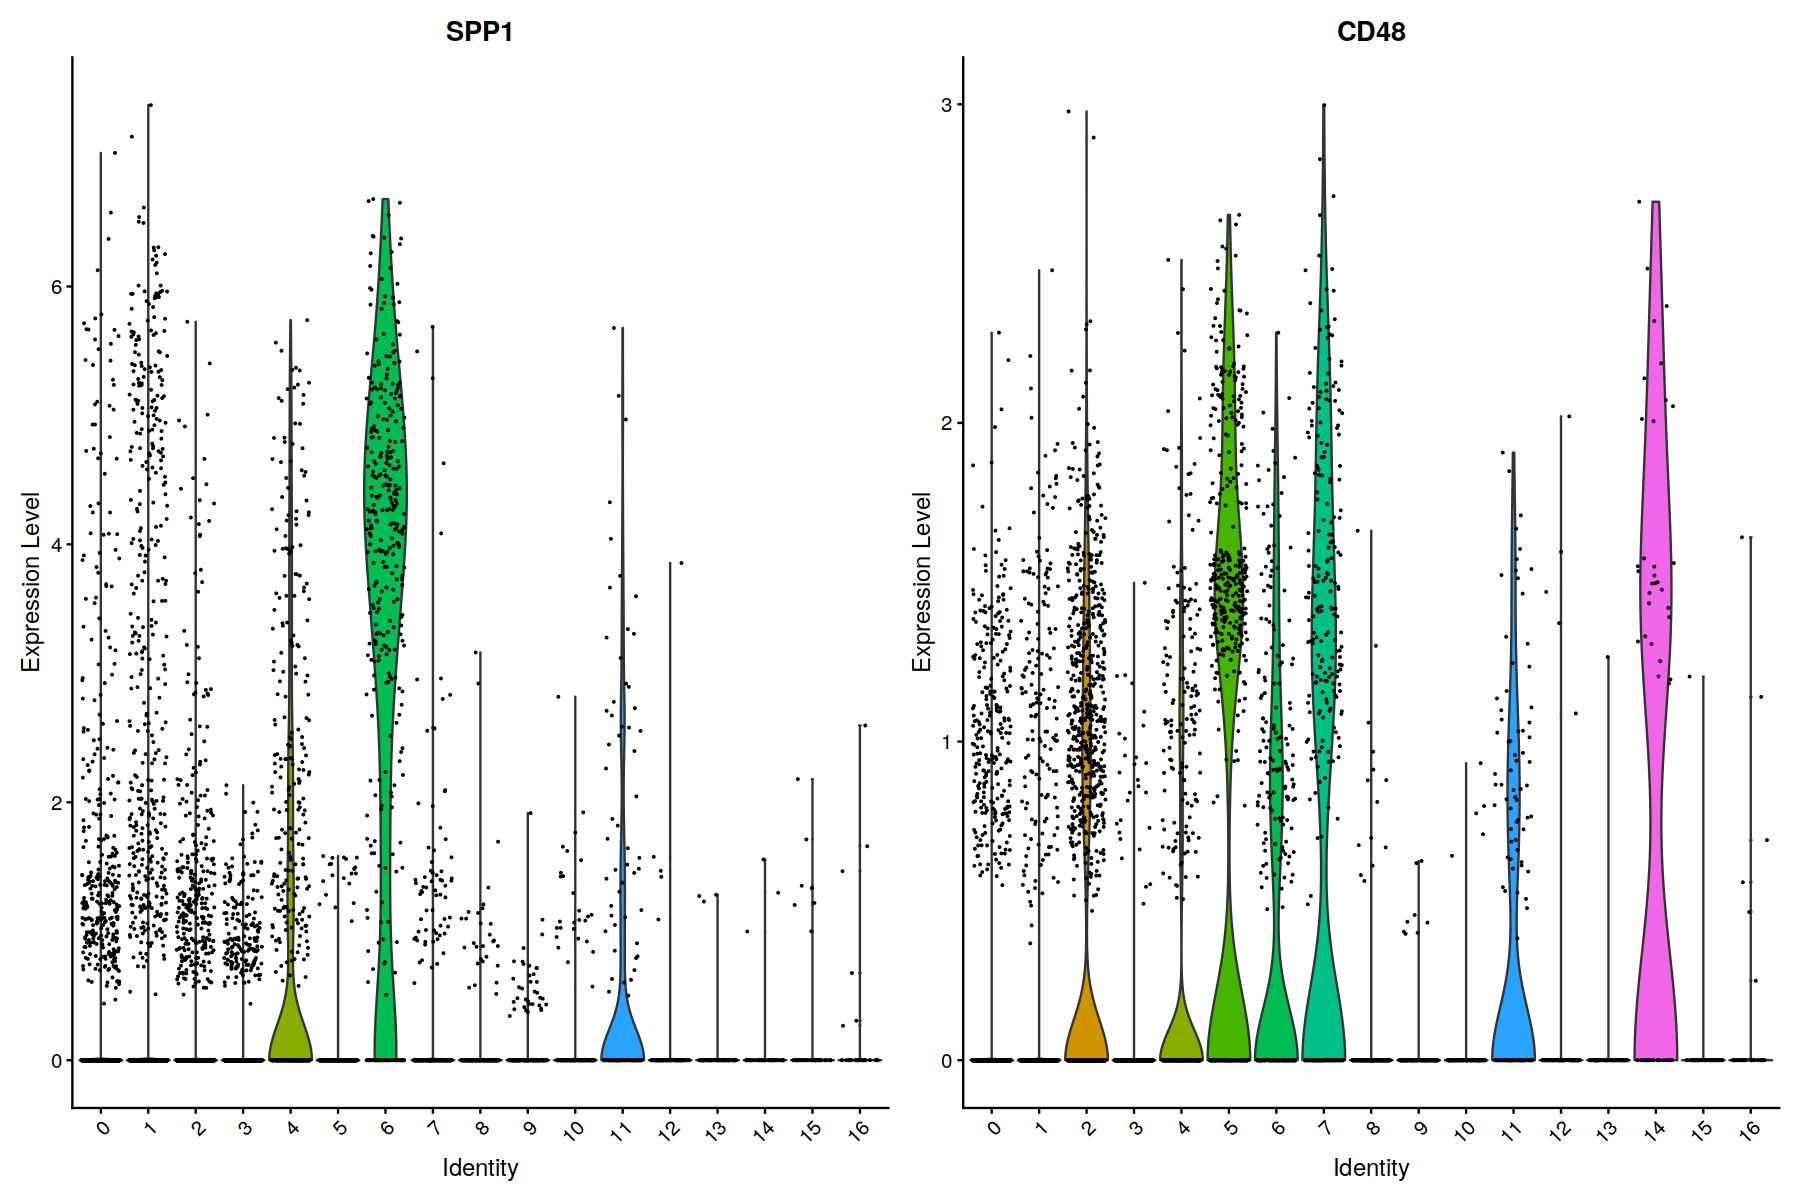

In [68]:
VlnPlot(combined, features = c("SPP1", "CD48"))

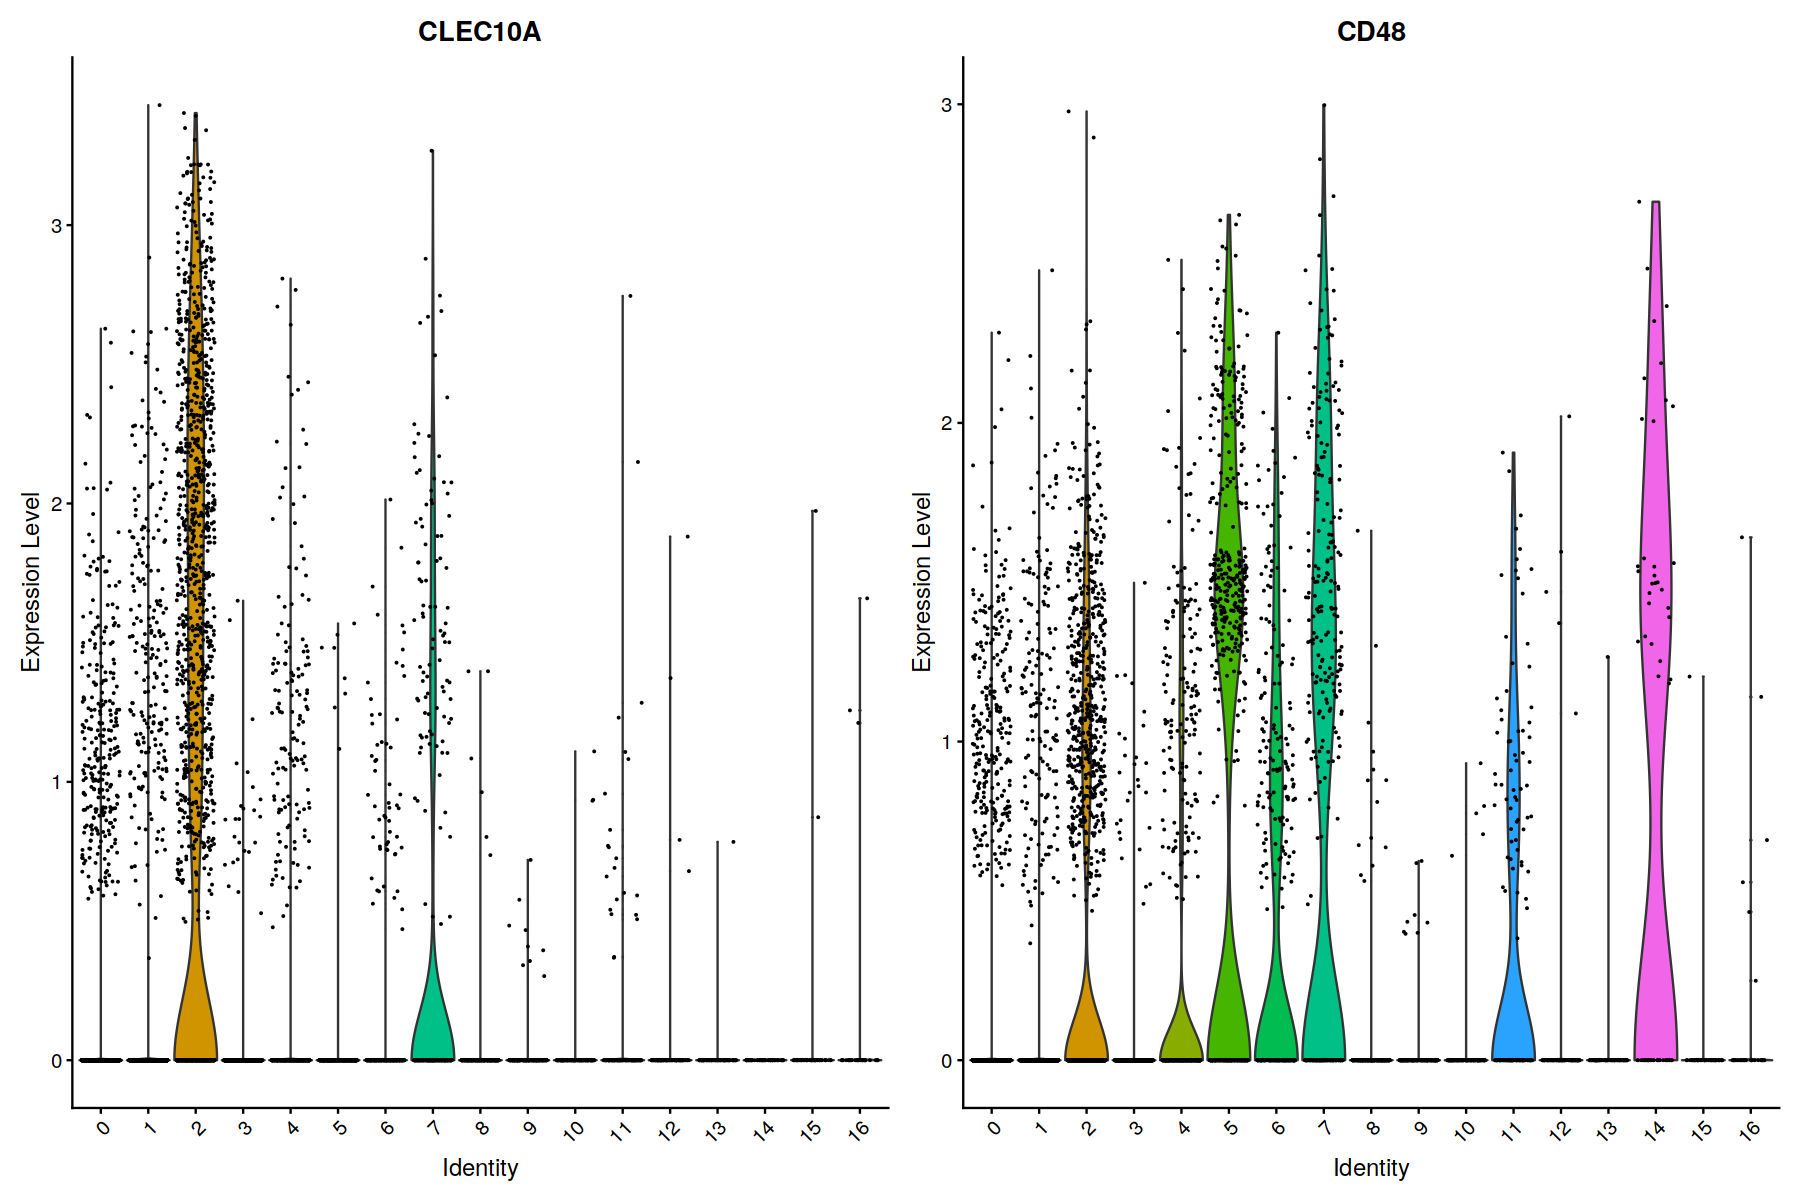

In [69]:
VlnPlot(combined, features = c("CLEC10A", "CD48"))

In [70]:
mertk.neg <- subset(combined, idents = c(2,6,7))

In [71]:
new.mertk.neg.cluster.ids <- c("CLEC10A+pos","SPP1+pos", "S100A12+pos")

In [72]:
names(new.mertk.neg.cluster.ids) <- levels(mertk.neg)
mertk.neg <- RenameIdents(mertk.neg, new.mertk.neg.cluster.ids)

Labeling the MERTK-negative populations was straightforward.The MERTK-positive populations, even though there is only one cluster, we recognize two types: those positive for TREM2 but negative for LYVE1, and those positive for LYVE1 with low TREM2 expression. We will separate these populations and conduct a new clustering analysis.

In [73]:
mertk.pos <- subset(combined, idents = 0)

In [ ]:
mertk.pos.list <- SplitObject(mertk.pos, split.by = "Sample")
mertk.pos.list <- lapply(X = mertk.pos.list, FUN = function(x) {
    x <- NormalizeData(x)
    x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = 2000)
})

In [ ]:
features <- SelectIntegrationFeatures(object.list = mertk.pos.list)
anchors <- FindIntegrationAnchors(object.list = mertk.pos.list, anchor.features = features)

In [76]:
table(mertk.pos$Sample)


HC0572 HC0701  SA131  SA138  SA168 
   464    687     74    201   1087 

In [78]:
mertk.pos <- IntegrateData(anchorset = anchors, k.weight = 70)
DefaultAssay(mertk.pos) <- "integrated"

Merging dataset 5 into 1

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Merging dataset 4 into 3

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Merging dataset 2 into 1 5

Extracting anchors for merged samples

Finding integration vectors

Warning message:
“Different cells in new layer data than already exists for scale.data”
Finding integration vector weights

Integrating data

Merging dataset 1 5 2 into 3 4

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data



In [79]:
mertk.pos <- ScaleData(mertk.pos, vars.to.regress = "percent.mt", verbose = FALSE)
mertk.pos <- RunPCA(mertk.pos, npcs = 50, verbose = FALSE)

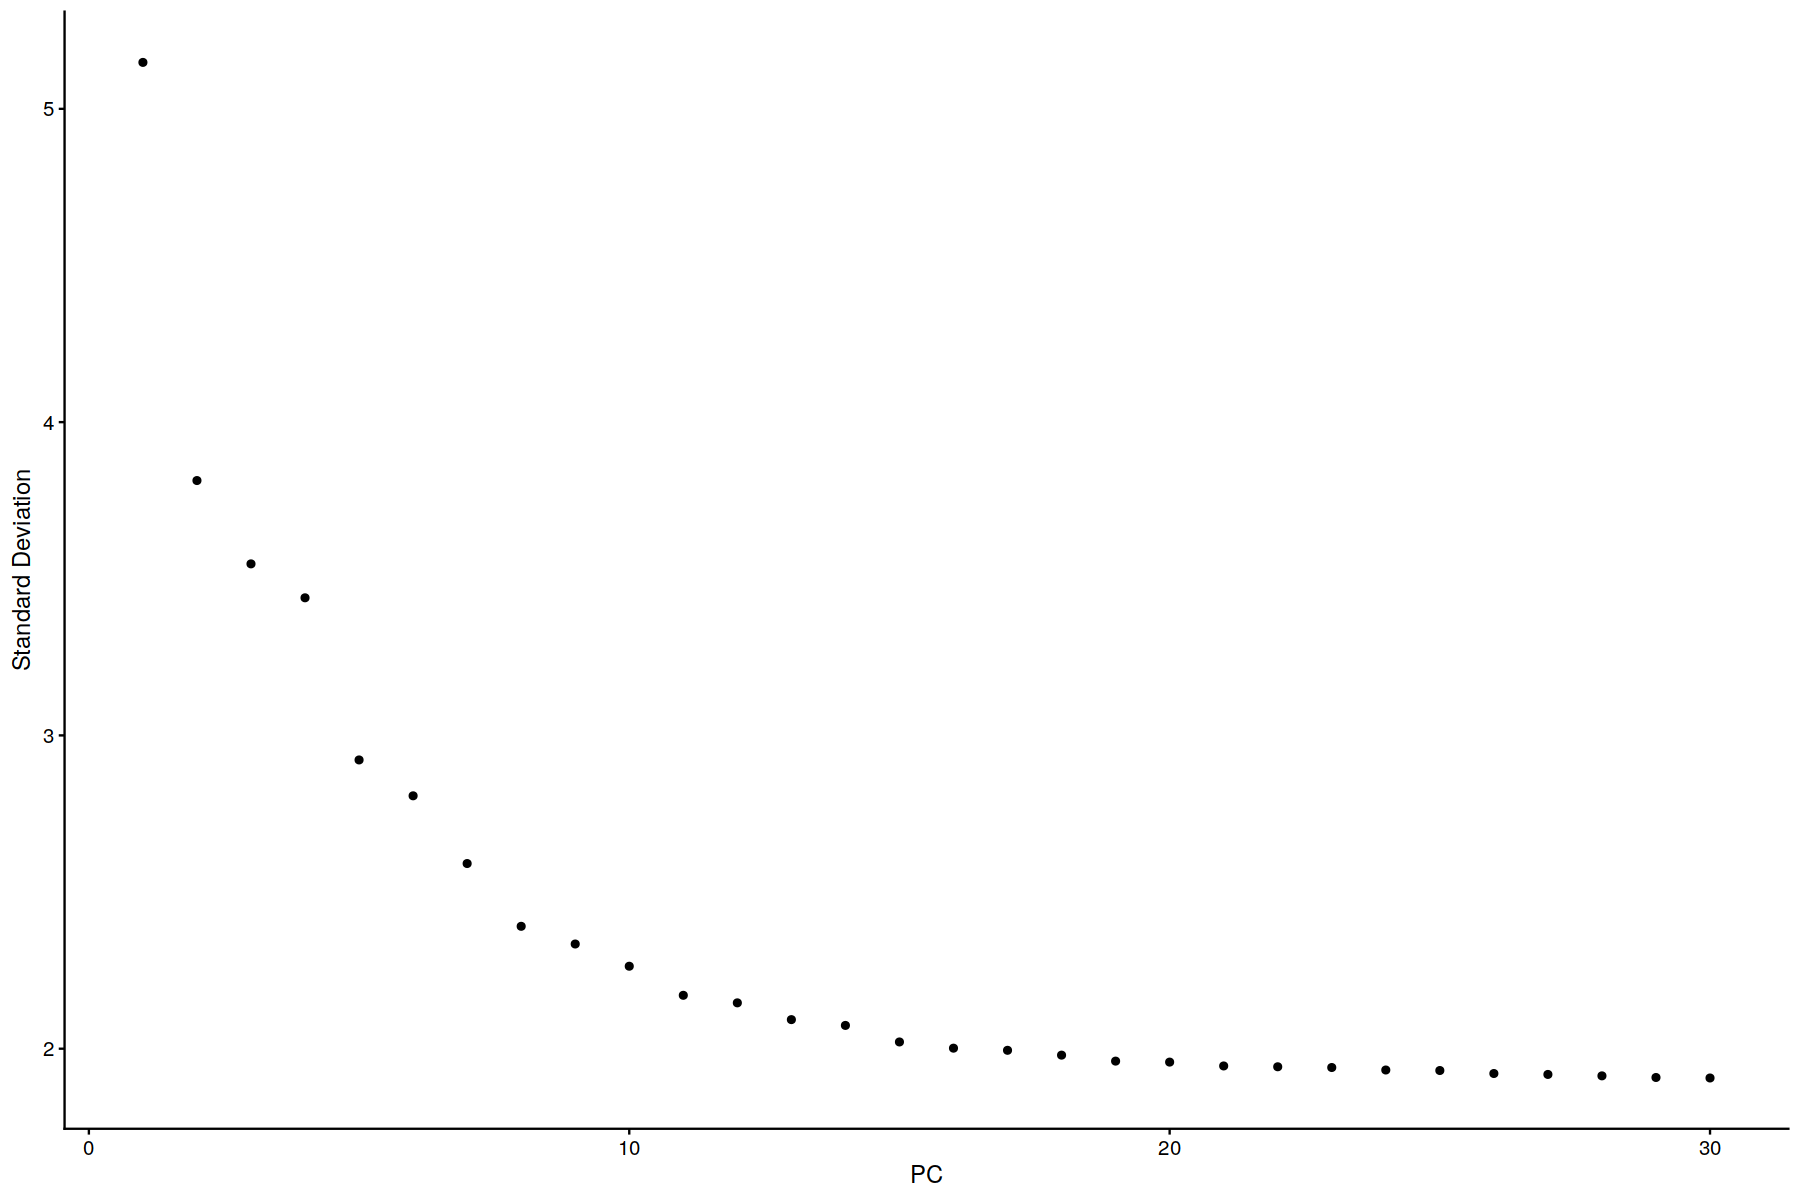

In [80]:
ElbowPlot(mertk.pos, ndims = 30)

In [ ]:
mertk.pos <- RunUMAP(mertk.pos, reduction = "pca", dims = 1:20)
mertk.pos <- FindNeighbors(mertk.pos, reduction = "pca", dims = 1:20)

In [82]:
# Select a range of resolutions
resolution.range.mertk <- seq(from = 0, to = 0.5, by = 0.1)

# Find clusters using a range of resolutions
mertk.pos <- FindClusters(object = mertk.pos, resolution = resolution.range.mertk)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2513
Number of edges: 120105

Running Louvain algorithm...
Maximum modularity in 10 random starts: 1.0000
Number of communities: 1
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2513
Number of edges: 120105

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9000
Number of communities: 1
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2513
Number of edges: 120105

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8176
Number of communities: 2
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2513
Number of edges: 120105

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7544
Number of communities: 4
Elapsed time: 0 seconds
Modularity Optimizer

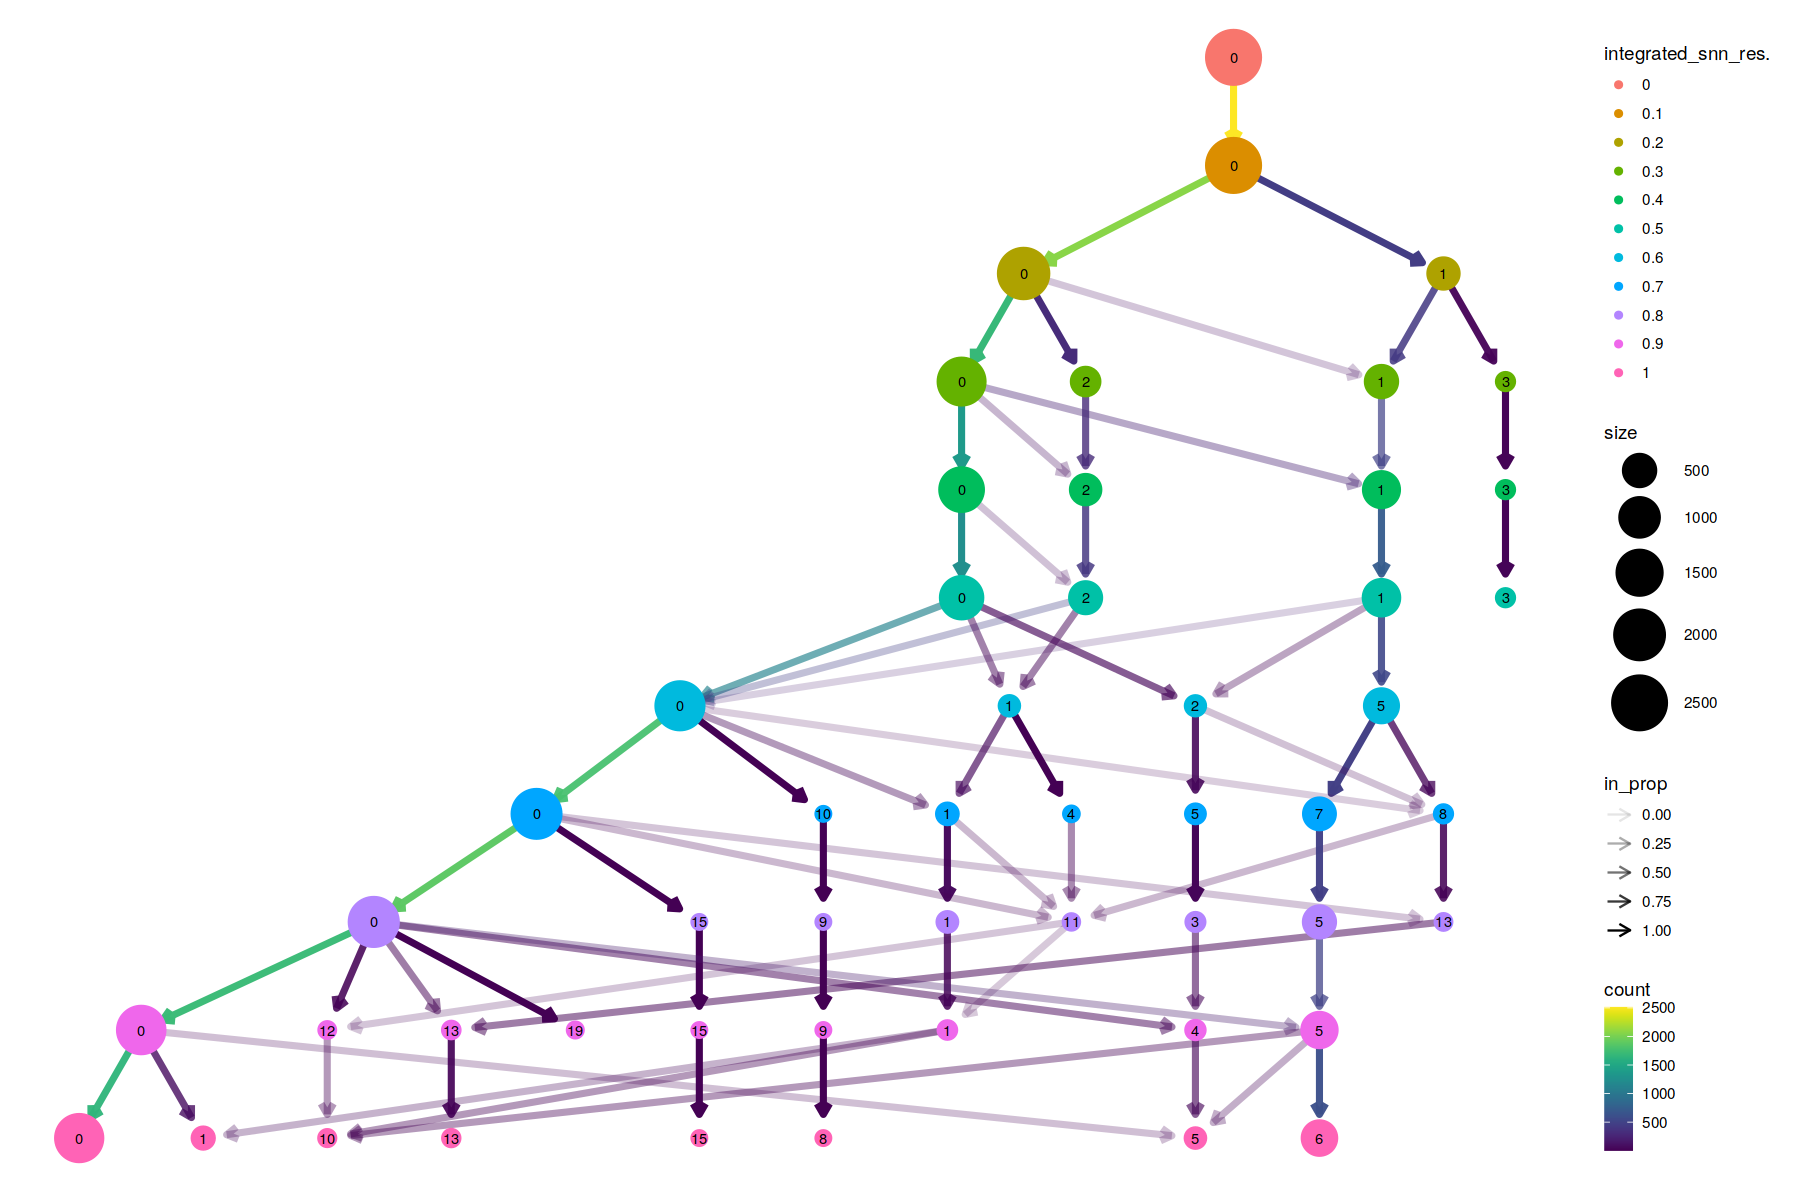

In [83]:
clustree(mertk.pos)

In [84]:
Idents(mertk.pos) <- mertk.pos$`integrated_snn_res.0.3`

In [85]:
DefaultAssay(mertk.pos) <- "RNA"

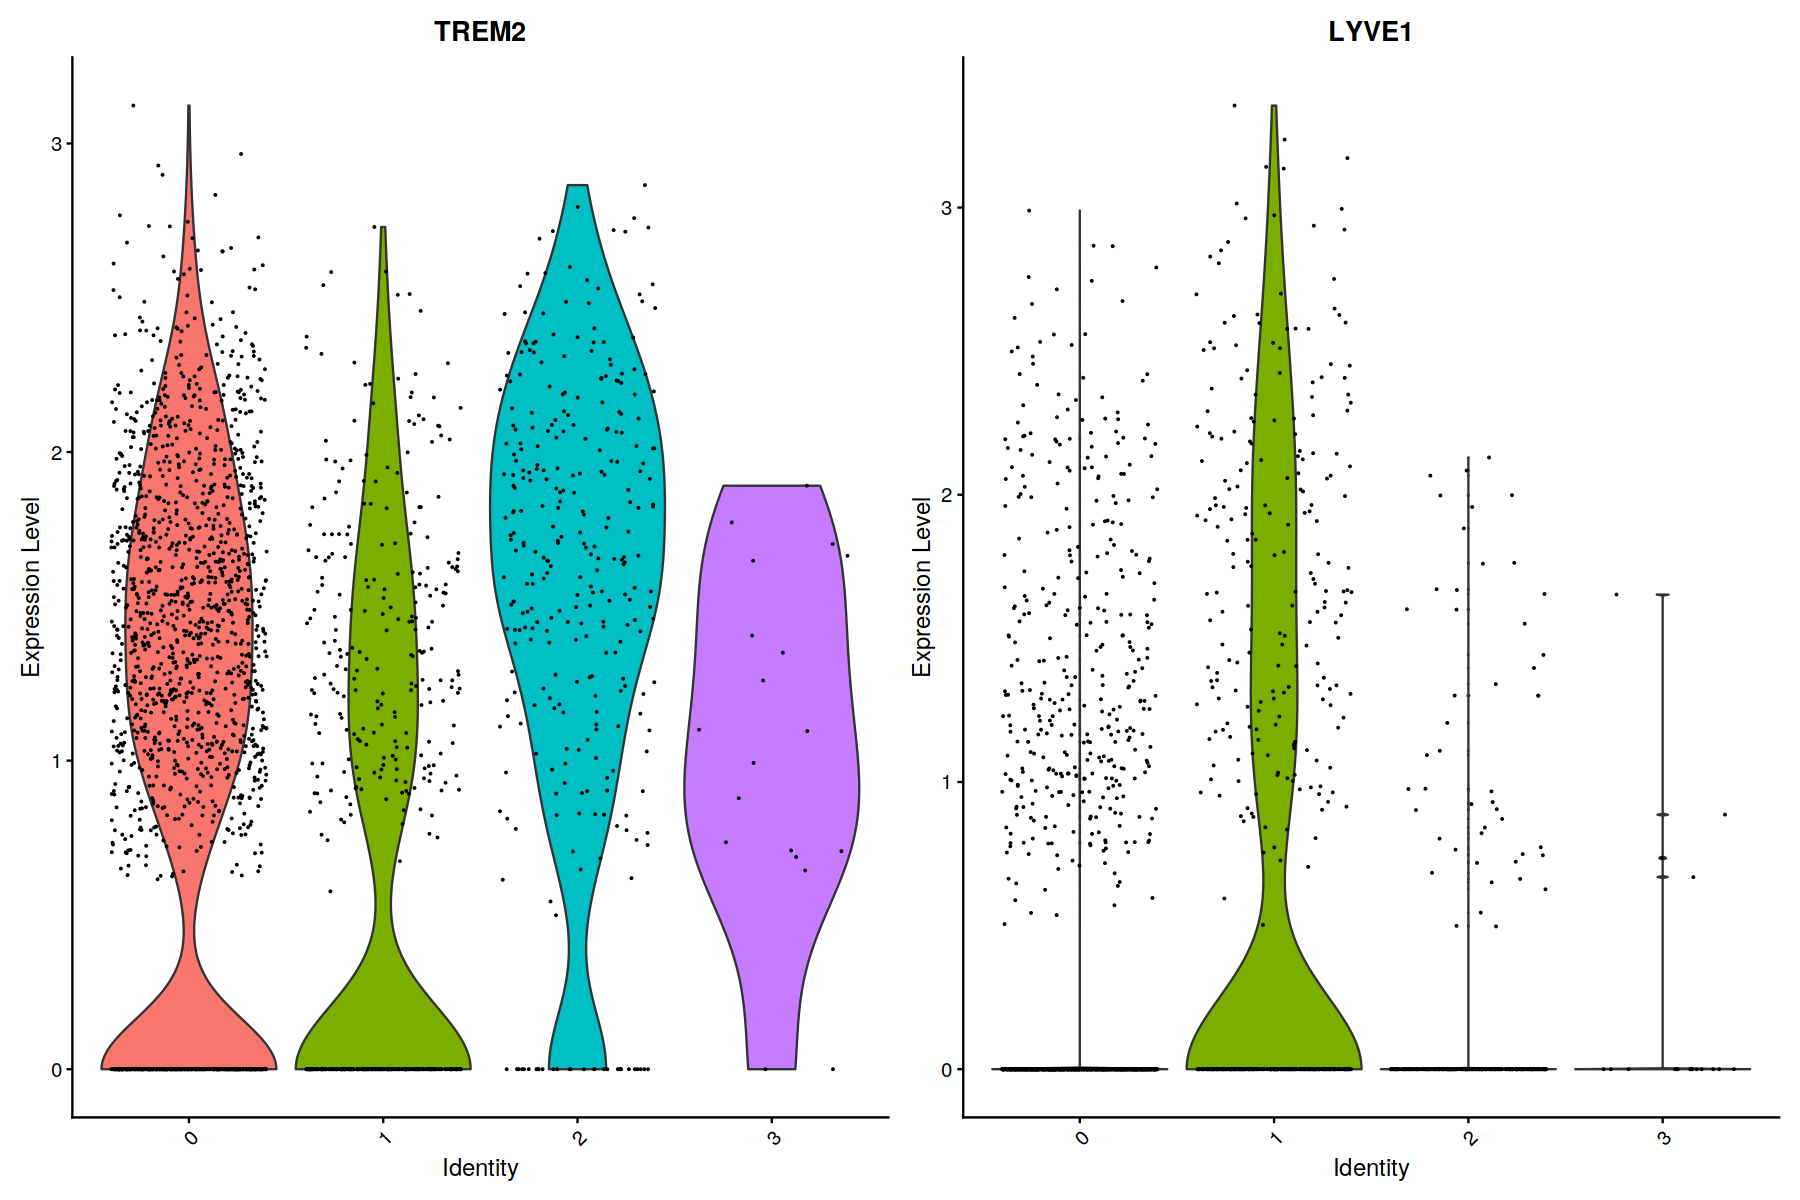

In [86]:
VlnPlot(mertk.pos, features = c("TREM2", "LYVE1"))

Lets just rename these cells with the macrophage names in the paper

In [90]:
new.mertk.pos.cluster.ids <- c("TREM2high","LYVE1+pos")

In [102]:
new.mertk.pos.cluster.ids

[1] "TREM2high" "LYVE1+pos"

In [ ]:
new.mertk.pos.cluster.ids <- levels(mertk.pos)
mertk.pos <- RenameIdents(mertk.pos, new.mertk.pos.cluster.ids)

In [ ]:
DefaultAssay(mertk.neg) <- "RNA"
DefaultAssay(mertk.pos) <- "RNA"
mertk.neg$cell.types <- Idents(mertk.neg)
mertk.pos$cell.types <- Idents(mertk.pos)
mertk.all <- merge(mertk.neg, y = mertk.pos)
mertk.all.list <- SplitObject(mertk.all, split.by = "Sample")
mertk.all.list <- lapply(X = mertk.all.list, FUN = function(x) {
    x <- NormalizeData(x)
    x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = 2000)
})

In [ ]:
features <- SelectIntegrationFeatures(object.list = mertk.all.list)
anchors <- FindIntegrationAnchors(object.list = mertk.all.list, anchor.features = features)

In [ ]:
mertk.all <- IntegrateData(anchorset = anchors)
DefaultAssay(mertk.all) <- "integrated"

In [110]:
table(mertk.all$Sample)


HC0572 HC0701  SA131  SA138  SA168 
   986    898    249    777   1891 

In [111]:
mertk.all <- ScaleData(mertk.all, vars.to.regress = "percent.mt", verbose = FALSE)
mertk.all <- RunPCA(mertk.all, npcs = 50, verbose = FALSE)

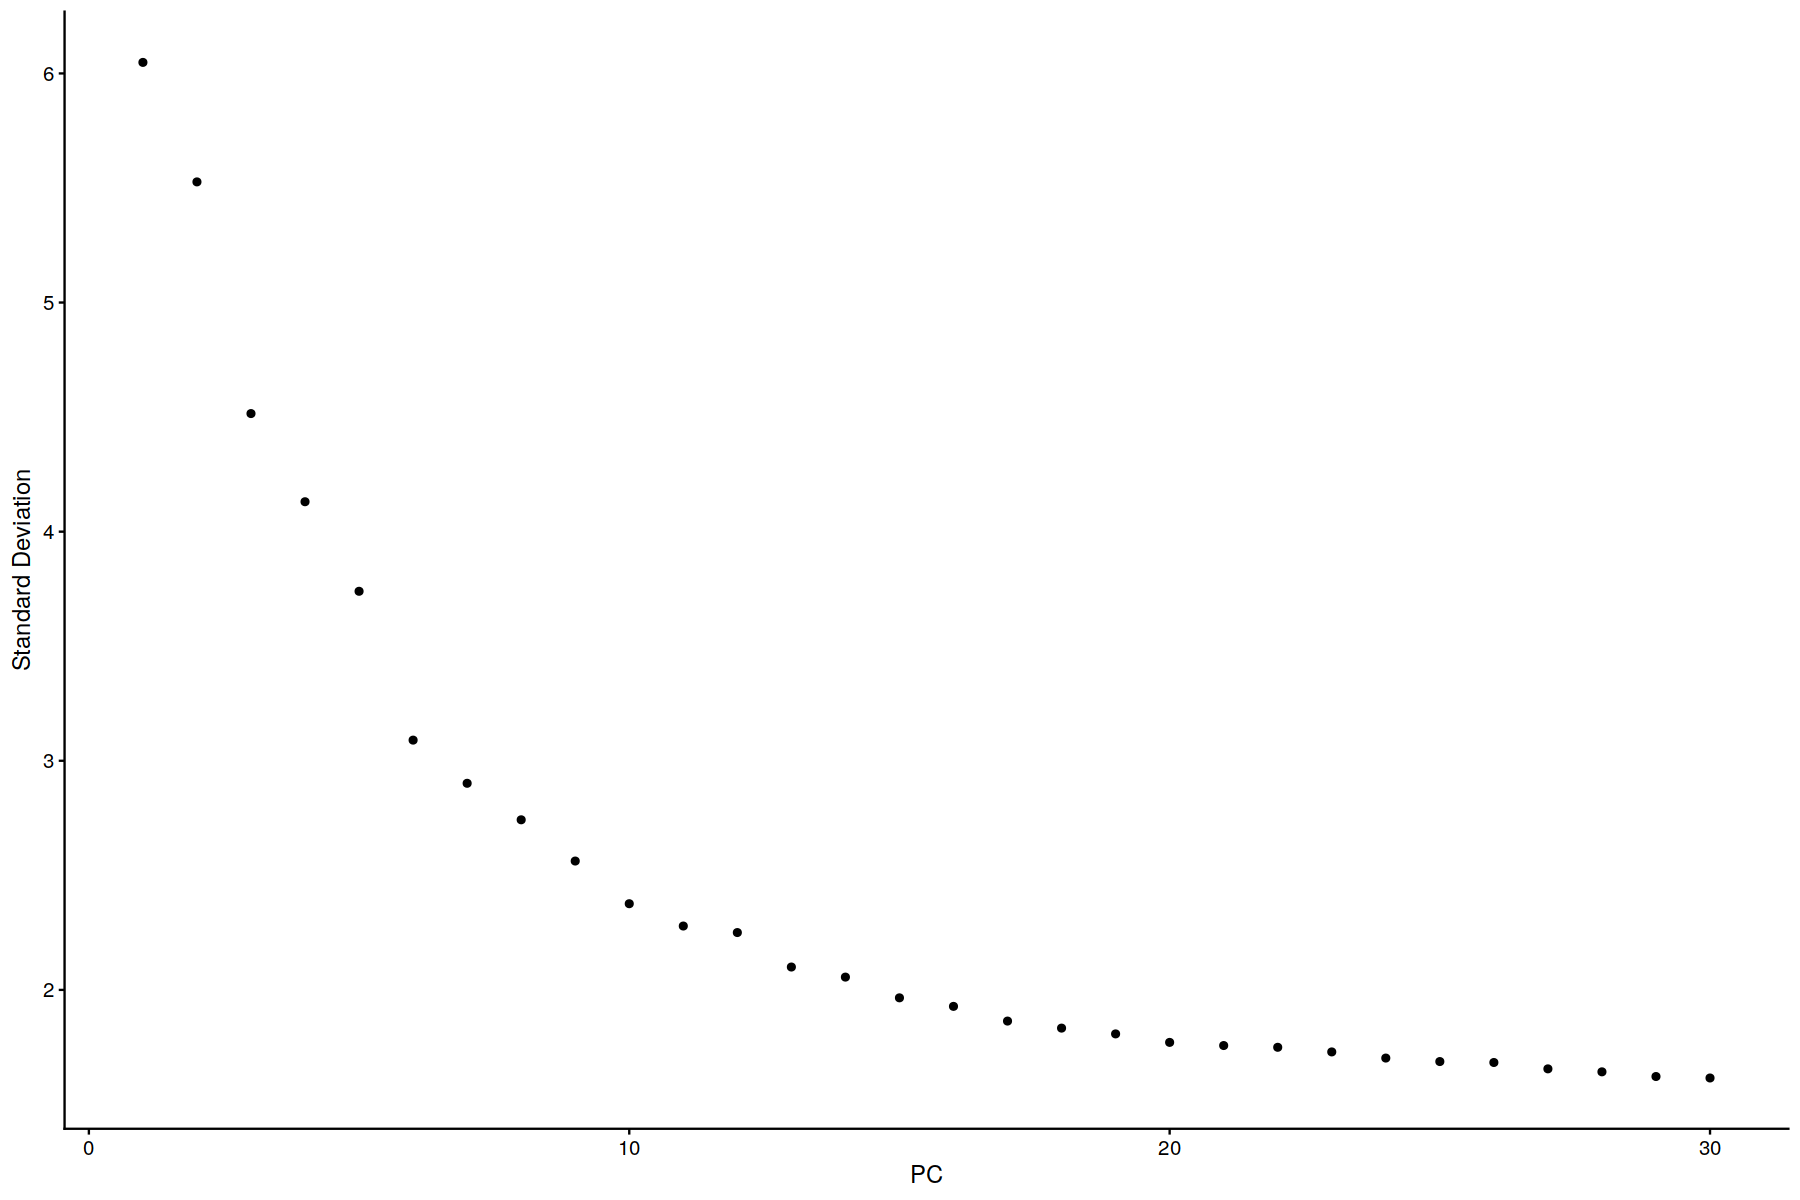

In [112]:
ElbowPlot(mertk.all, ndims = 30)

In [ ]:
mertk.all <- RunUMAP(mertk.all, reduction = "pca", dims = 1:20)
mertk.all <- FindNeighbors(mertk.all, reduction = "pca", dims = 1:20)

In [114]:
# Select a range of resolutions
resolution.range.mertk.all <- seq(from = 0, to = 0.5, by = 0.1)

# Find clusters using a range of resolutions
mertk.all <- FindClusters(object = mertk.all, resolution = resolution.range.mertk.all)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4801
Number of edges: 184920

Running Louvain algorithm...
Maximum modularity in 10 random starts: 1.0000
Number of communities: 1
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4801
Number of edges: 184920

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9626
Number of communities: 5
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4801
Number of edges: 184920

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9443
Number of communities: 8
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4801
Number of edges: 184920

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9311
Number of communities: 9
Elapsed time: 0 seconds
Modularity Optimizer

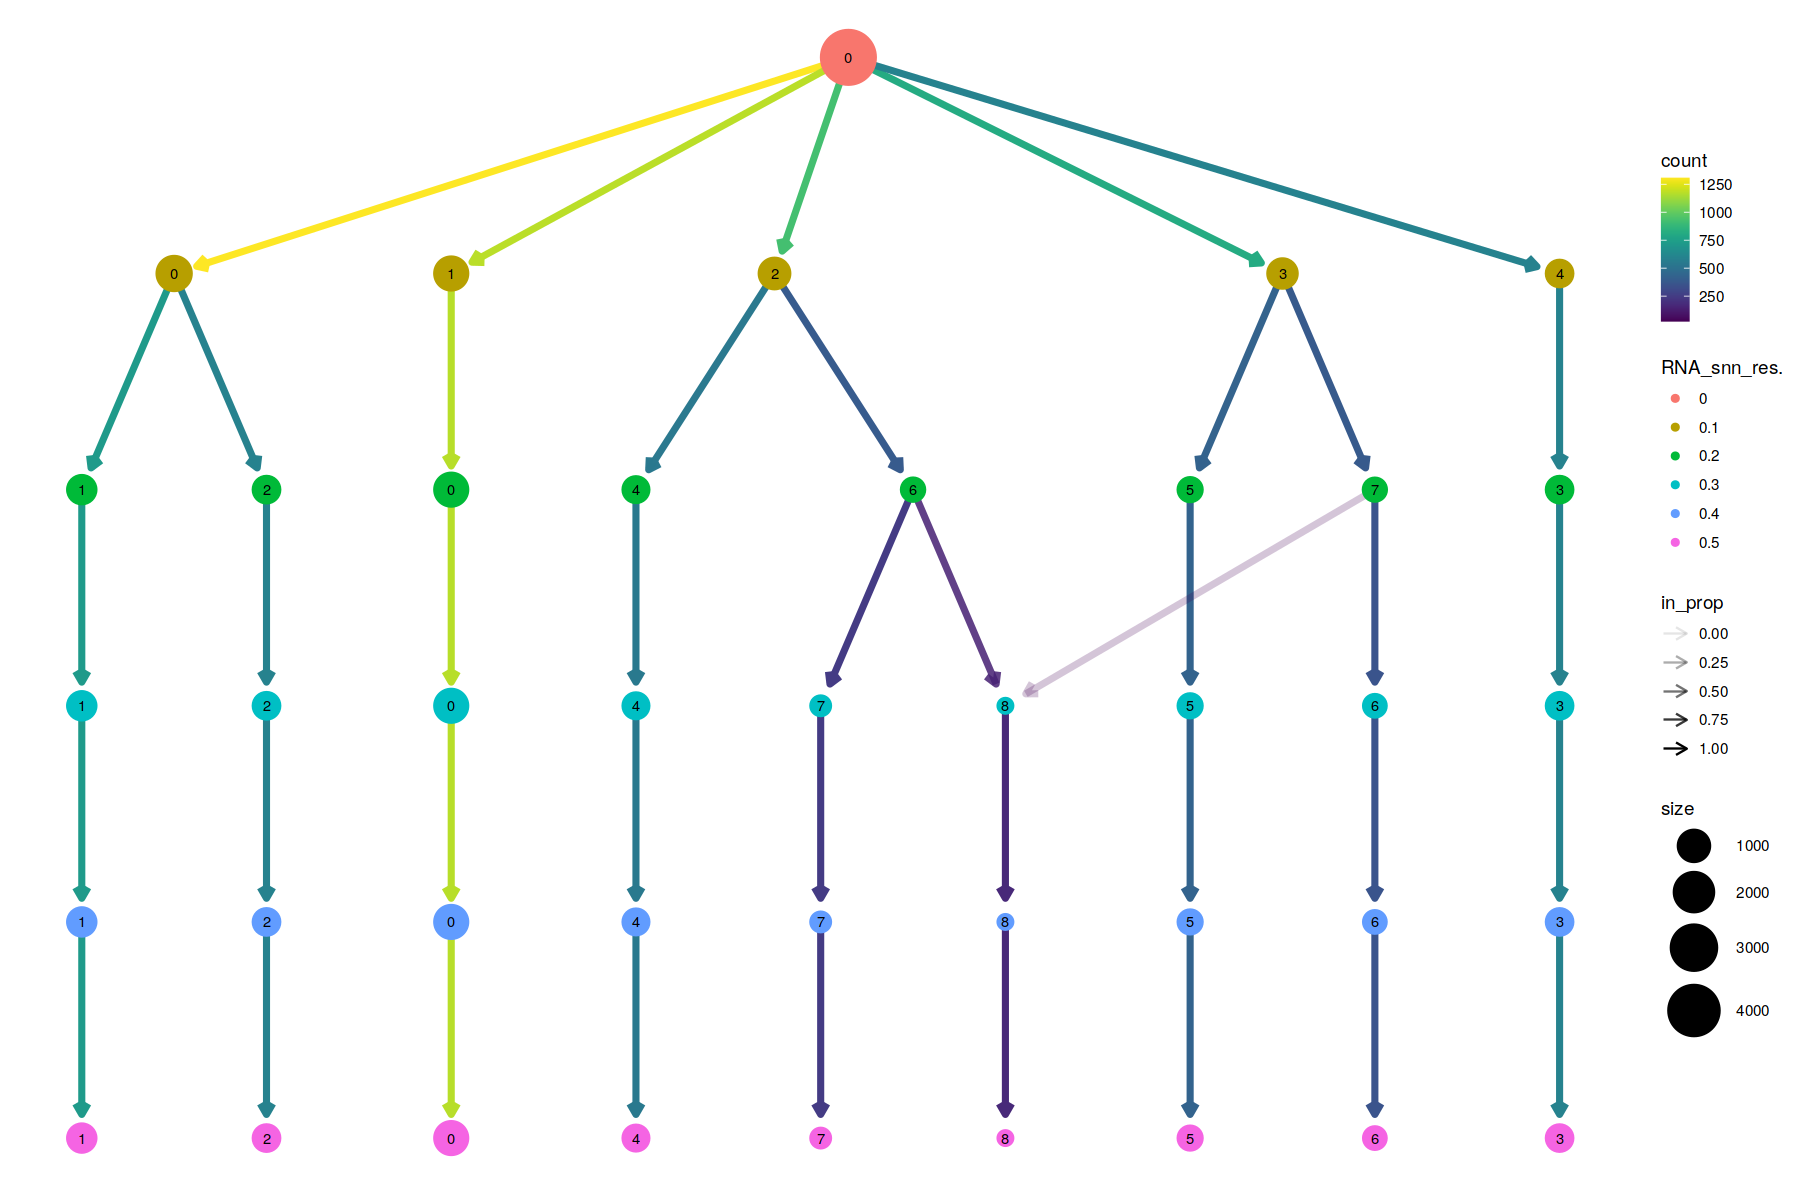

In [115]:
clustree(mertk.all)

In [116]:
Idents(mertk.all) <- mertk.all$`integrated_snn_res.0.1`

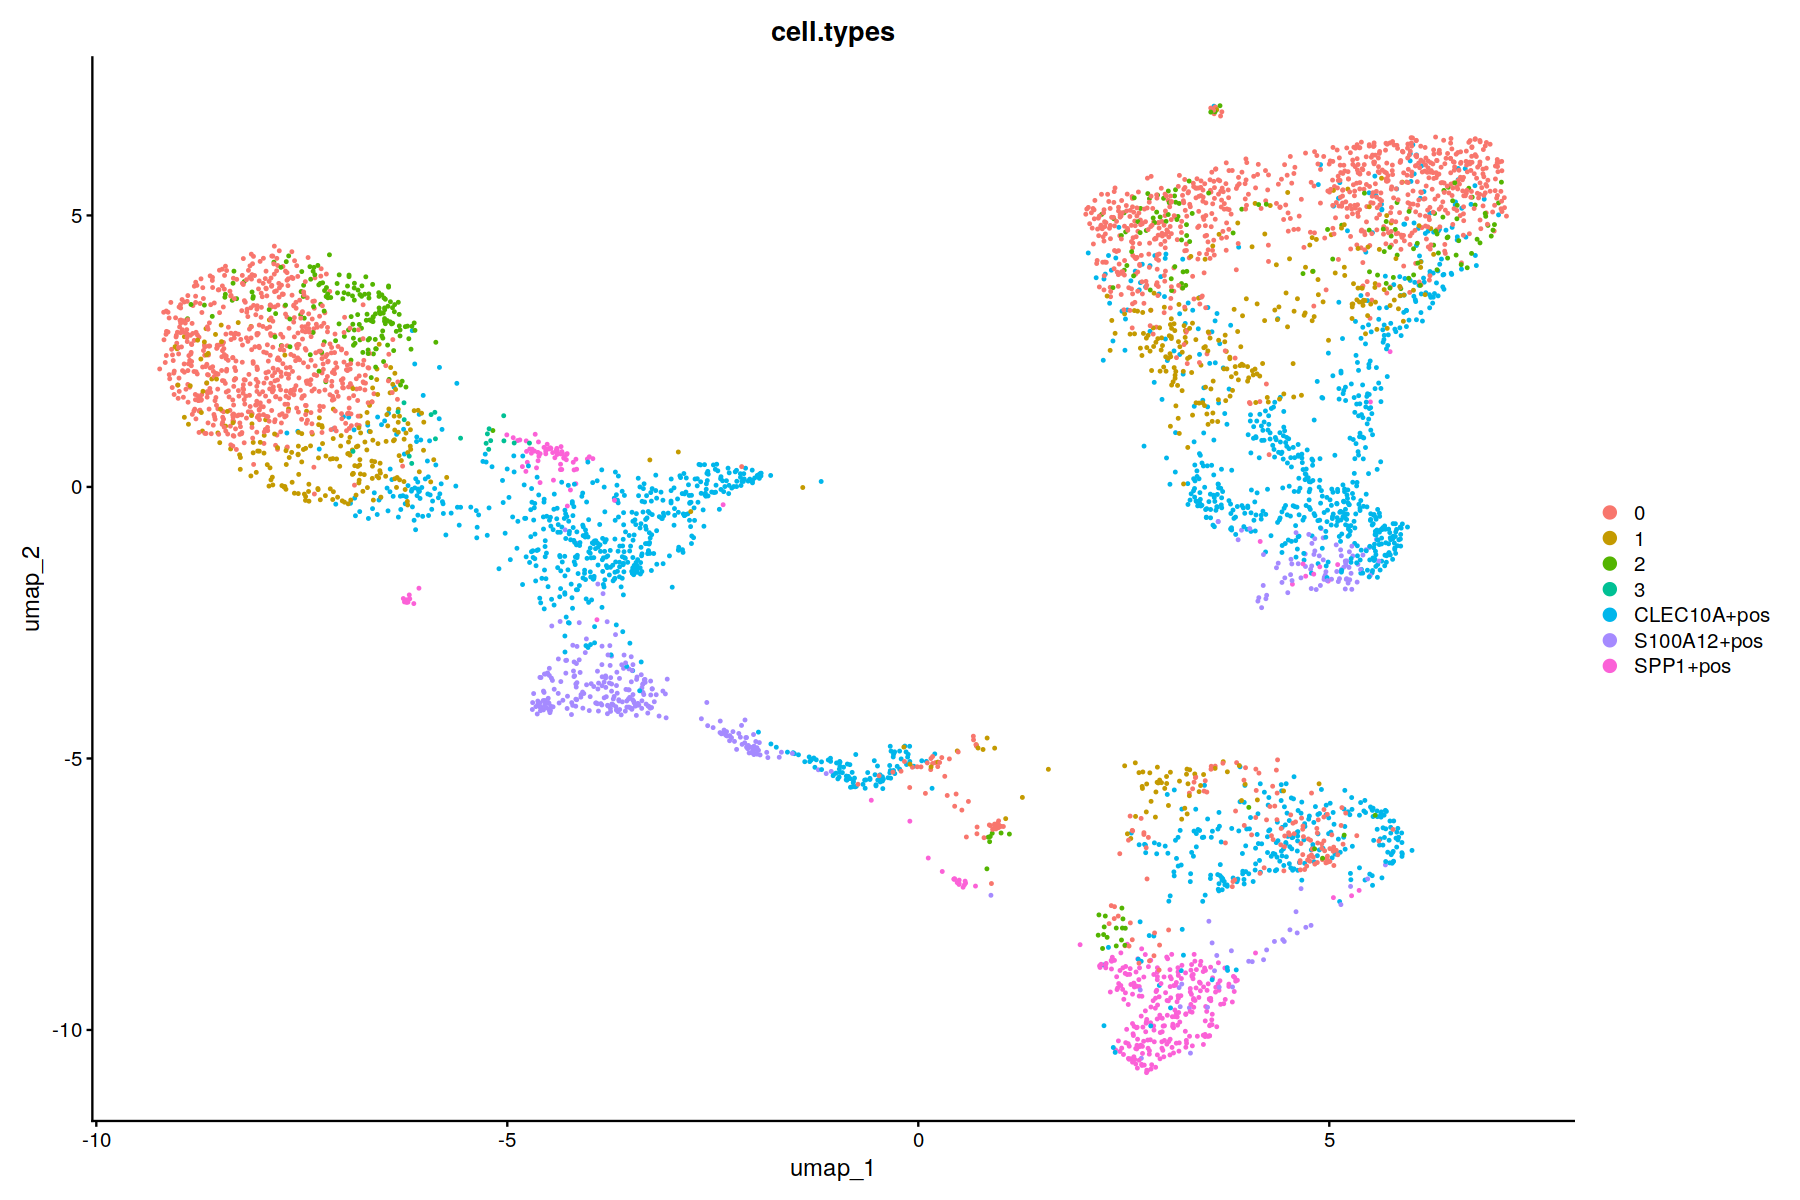

In [117]:
DimPlot(mertk.all, group.by = "cell.types")

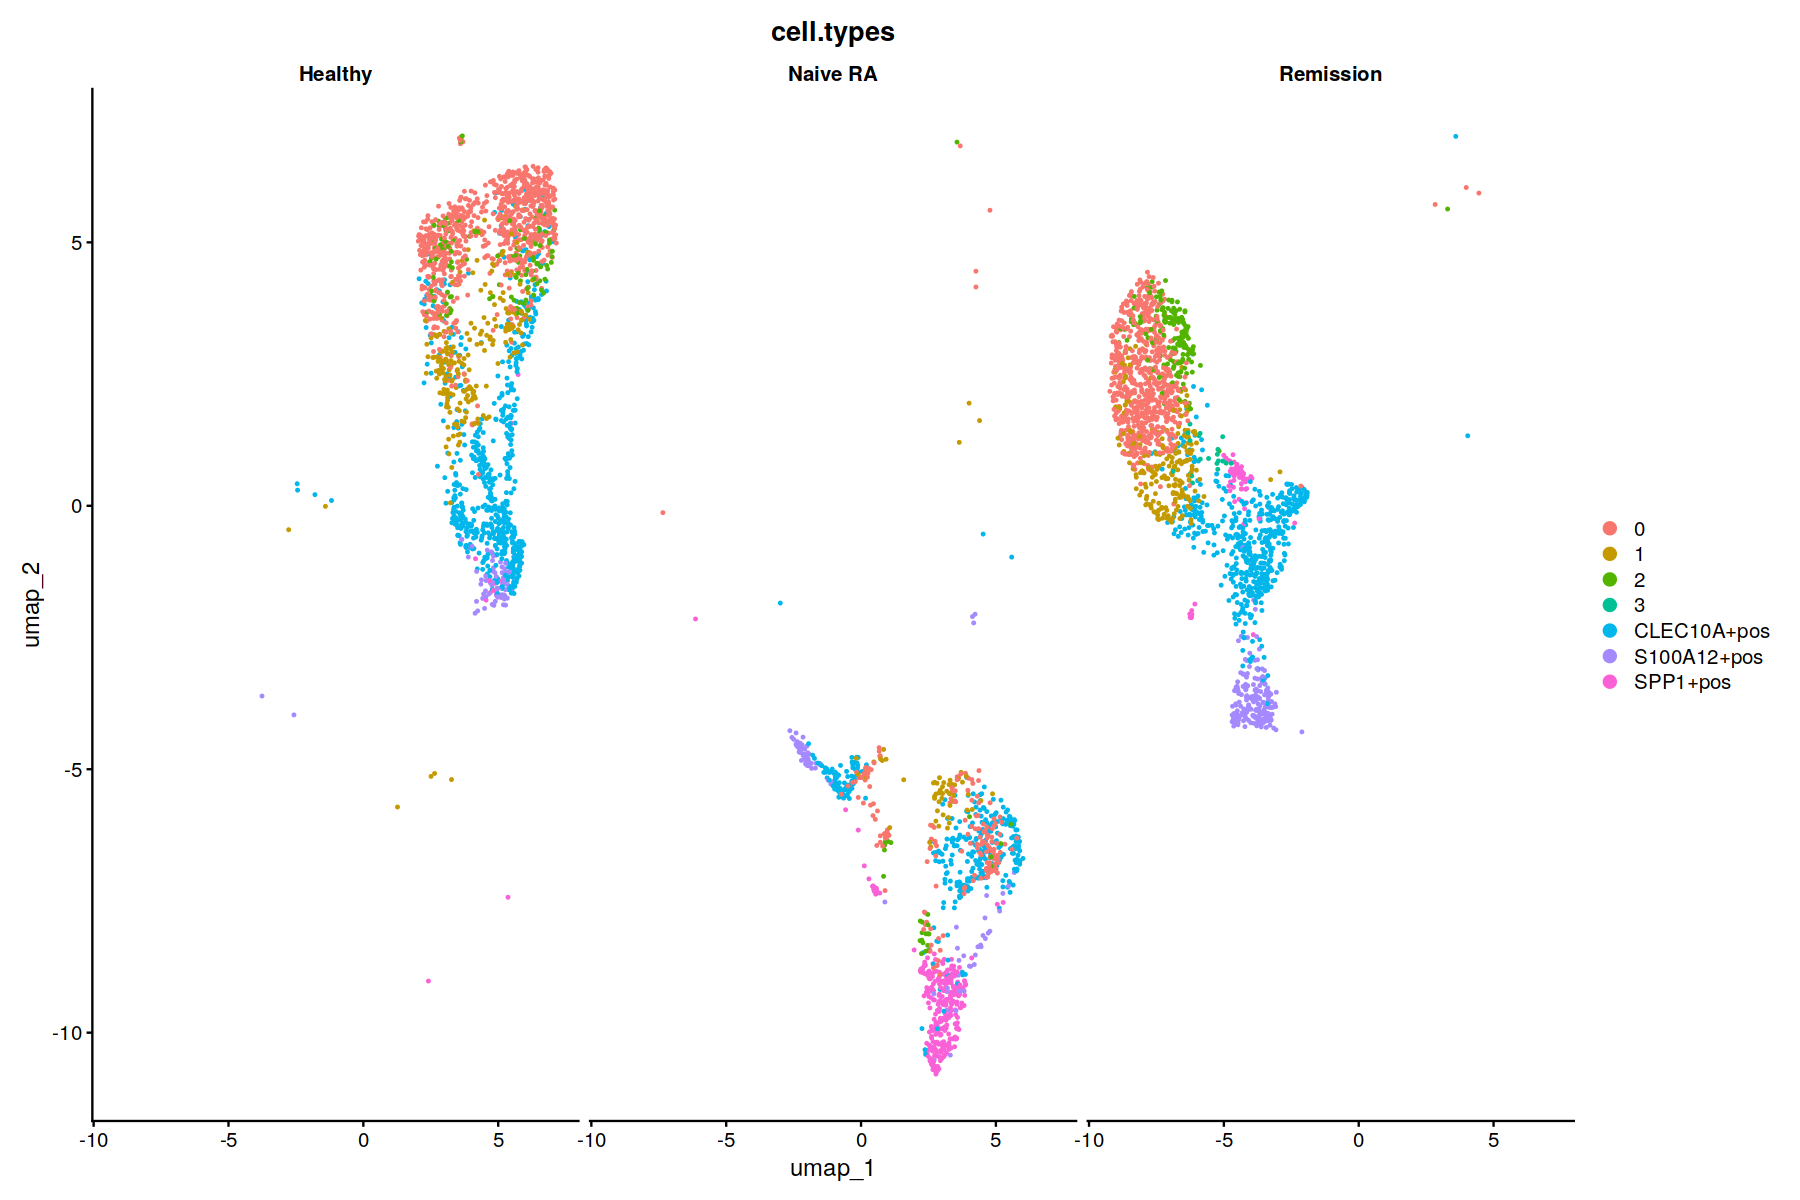

In [118]:
DimPlot(mertk.all, group.by = "cell.types", split.by = "Group")

In [119]:
mertk.all

An object of class Seurat 
36764 features across 4801 samples within 2 assays 
Active assay: RNA (33694 features, 2000 variable features)
 19 layers present: scale.data.1, scale.data.1.2, scale.data.2.2, scale.data.3.2, scale.data.4.2, scale.data.5.2, data.1, counts.1, data.1.2, counts.1.2, data.2.2, counts.2.2, data.3.2, counts.3.2, data.4.2, counts.4.2, data.5.2, counts.5.2, scale.data
 1 other assay present: integrated
 2 dimensional reductions calculated: pca, umap

After Analyzing the one cell population analysis followed by 

## Differential Expression Analysis
## Gene Set Enrichment Analysis

